In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os

import seaborn as sns
from matplotlib.colors import to_rgb

from vlti_gravity_sim import wavefront

from scipy.interpolate import interp1d
from scipy.optimize import least_squares,curve_fit
import h5py
from scipy.signal import fftconvolve

from vlti_gravity_sim.wavefront import Wavefront
import poppy
from scipy.ndimage import gaussian_filter
import poppy
from scipy.ndimage import zoom,shift
from scipy.stats import circstd
import time
from telfit import Modeler
from telfit import TelluricFitter, DataStructures
from astropy.io import fits
import multiprocessing as mp
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
root = "/home/sauter/PhD/beta Pic/betaPic/betaPic/"

all_files = os.listdir(root)
files_star = []
for file in all_files:
    if "GRAVI.2024-12-20" in file and ".fits" in file:
        h = fits.open(root+file)[0].header
        #print(h["HIERARCH ESO ACQ FIBER SC1X"])
        if h["HIERARCH ESO DET2 SEQ1 DIT"] == 3 and "GRAVITY_PARALLEL_OBS" in h["ORIGFILE"]:
            files_star.append(file)
files_star.sort()
print('beta Pic')
for file in files_star:
    print(file)

fiber_pos_sc = np.empty((18,8))
fiber_pos_ft = np.empty((18,8))

reference_pos = [(128, 87), (368, 88), (620, 96), (877, 91)]

for k in range(18):
    f = files_star[k][6:-5]
    file_path = '/home/sauter/PhD/beta Pic/betaPic/betaPic/GRAVI.'+f+'.fits'

    header = fits.open(file_path)[0].header

    # Load detector frame positions
    frame = np.array([
        [header.get(f"HIERARCH ESO DET1 FRAM{i+1} STRX", np.nan) for i in range(16)],
        [header.get(f"HIERARCH ESO DET1 FRAM{i+1} STRY", np.nan) for i in range(16)],
    ])

    x = np.arange(4) * 250
    xx, yy = np.meshgrid(x, x)
    frame0 = np.vstack([xx.ravel(), yy.ravel()])

    corx = header.get("HIERARCH ESO ACQ ARD CORX", 0.0)
    cory = header.get("HIERARCH ESO ACQ ARD CORY", 0.0)

    for i in range(4):
        # SC fiber
        x_sc = header.get(f"HIERARCH ESO ACQ FIBER SC{i+1}X", np.nan)
        y_sc = header.get(f"HIERARCH ESO ACQ FIBER SC{i+1}Y", np.nan)
        # FT fiber
        x_ft = header.get(f"HIERARCH ESO ACQ FIBER FT{i+1}X", np.nan)
        y_ft = header.get(f"HIERARCH ESO ACQ FIBER FT{i+1}Y", np.nan)

        for j in range(16):
            if frame[0, j] <= x_sc <= frame[0, j] + 250 and frame[1, j] <= y_sc <= frame[1, j] + 250:
                fiber_pos_sc[k,2*i] = x_sc - frame[0, j] + frame0[0, j] - reference_pos[i][0] - corx
                fiber_pos_sc[k,2*i+1] = y_sc - frame[1, j] + frame0[1, j] - reference_pos[i][1] - cory
            if frame[0, j] <= x_ft <= frame[0, j] + 250 and frame[1, j] <= y_ft <= frame[1, j] + 250:
                fiber_pos_ft[k,2*i] = x_ft - frame[0, j] + frame0[0, j] - reference_pos[i][0] - corx
                fiber_pos_ft[k,2*i+1] = y_ft - frame[1, j] + frame0[1, j] - reference_pos[i][1] - cory

fiber_pos_fit = np.array(
    [[-0.21896664,0.19972322,0.41155727,-0.36867963,0.40242323,0.27944667,-0.1941593,0.34197984],
     [-0.52224748,-1.69318736,0.29384434,-1.43410681,0.47781054,0.35862603,-0.5401314,-0.26973552],
     [-0.51947643,-1.81607811,0.56185056,-1.68417127,1.08570983,-1.05152,-0.10705983,-0.34444707],
     [-0.71397993,-2.09876895,1.4401223,-1.73683024,0.67965139,-0.66983159,-0.96031447,-0.1547855],
     [-0.52077755,-2.52337689,0.5180822,-1.67803546,0.2342265,-1.77720648,-1.05556505,-0.86471337],
     [-0.58393454,-3.07076665,0.0634982,-2.22831701,-0.3924208,-1.23936736,-1.58899241,-1.08402646],
     [-1.34883906,-2.67774482,0.37283387,-2.28153333,0.5845338,-1.00515726,-0.76095837,-1.13680319],
     [-1.6230685,-3.2833436,-0.03488063,-2.47255556,-0.42804723,-1.54904216,-1.22315749,-1.11680792],
     [-1.04879234,-3.22916787,0.68310924,-3.57057263,-0.27863421,-1.85905185,-1.45048532,-1.13055773],
     [-0.60319714,-3.81037884,-0.07117466,-2.54239394,0.58317455,-1.55763608,-1.83752304,-1.21727272],
     [-1.72352421,-3.72974728,-0.3121477,-3.01400149,-0.16009924,-2.78044342,-1.30196782,-2.3274349],
     [-1.61539798,-3.48823303,-0.42872872,-3.47335776,-0.00595047,-2.21114725,-1.23829298,-2.23987959],
     [-1.14310299,-3.86698542,0.32355341,-4.00405286,0.20423202,-1.35725545,-1.81427106,-2.89384077],
     [-1.86263094,-4.17630726,-0.75268557,-4.45931191,-0.28244583,-2.61187513,-2.24071935,-2.25883906],
     [-1.30280404,-4.27515627,-0.45278103,-4.20968388,0.00831623,-2.7207254,-2.02935703,-2.82146549],
     [-1.15803615,-4.70980661,-0.66067601,-4.43032922,-0.02796098,-3.64740644,-2.15577906,-3.75485424],
     [-1.13750194,-5.20523685,-1.00207717,-4.73587082,-0.59527166,-3.61958326,-1.19106127,-3.01322174],
     [-1.00341937,-4.59049925,-1.4351741,-4.34741228,-0.61295698,-4.01186226,-2.61197892,-3.14765963]
     ])

beta Pic
GRAVI.2024-12-20T00:51:57.856.fits
GRAVI.2024-12-20T01:31:54.958.fits
GRAVI.2024-12-20T02:10:16.056.fits
GRAVI.2024-12-20T02:12:16.060.fits
GRAVI.2024-12-20T02:37:52.126.fits
GRAVI.2024-12-20T02:54:43.169.fits
GRAVI.2024-12-20T03:20:13.233.fits
GRAVI.2024-12-20T03:36:55.276.fits
GRAVI.2024-12-20T04:02:37.342.fits
GRAVI.2024-12-20T04:21:04.388.fits
GRAVI.2024-12-20T04:46:25.452.fits
GRAVI.2024-12-20T05:02:52.495.fits
GRAVI.2024-12-20T05:30:10.564.fits
GRAVI.2024-12-20T05:46:49.607.fits
GRAVI.2024-12-20T06:12:13.671.fits
GRAVI.2024-12-20T06:28:46.713.fits
GRAVI.2024-12-20T06:54:13.778.fits
GRAVI.2024-12-20T07:10:55.820.fits


3.0693425157954373 2.8408418686915367
3.087986711372237 3.109199855767288
2.6573382106321404 2.9830749492806423
2.948876737690697 3.304550133715477


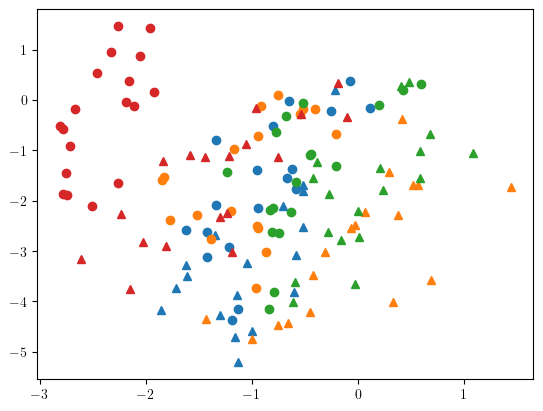

0.7500176899750784 0.5820019466900233
0.7427577459903807 0.5069470112992778
0.6541345367549362 0.6201843162681451
0.7131218484899029 0.6023871730443704


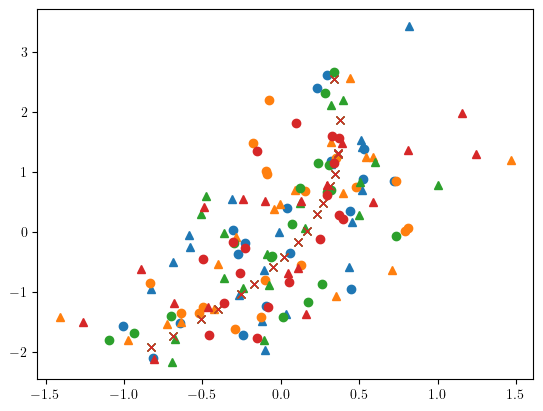

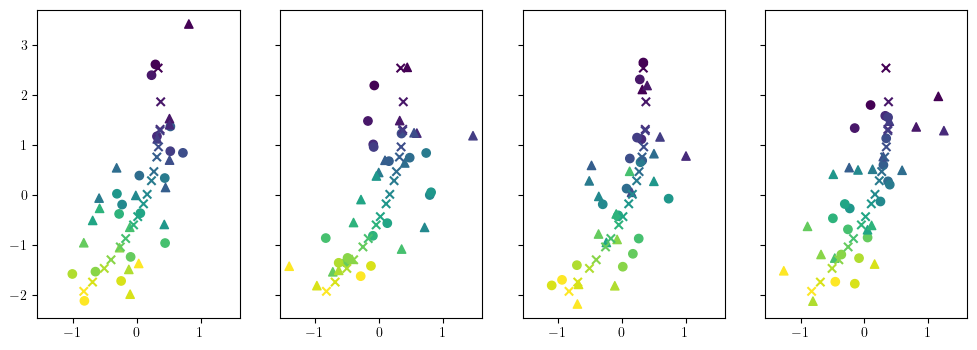

[[-0.899      -1.74429444]
 [-1.04396667 -1.53103333]
 [-0.50961667 -1.49448889]
 [-2.41837778 -0.30580556]]
[[-1.03609429 -3.22472566]
 [-0.02677079 -2.92617867]
 [ 0.08201615 -1.8350577 ]
 [-1.35009856 -1.6352425 ]]
[[-1.21837222 -2.09555   ]
 [-1.34047222 -2.04725   ]
 [-1.43777222 -2.28505   ]
 [-3.05497222 -0.47425   ]]


In [3]:
fiber_cor = np.empty((4,2))
fiber_cor_fit = np.empty((4,2))
fiber_cor_ft = np.empty((4,2))

plt.figure()
for i in range(4):
    fiber_cor[i,0] = np.mean(fiber_pos_sc[:,2*i])
    fiber_cor[i,1] = np.mean(fiber_pos_sc[:,2*i+1])
    fiber_cor_ft[i,0] = np.mean(fiber_pos_ft[:,2*i])
    fiber_cor_ft[i,1] = np.mean(fiber_pos_ft[:,2*i+1])
    fiber_cor_fit[i,0] = np.mean(fiber_pos_fit[:,2*i])
    fiber_cor_fit[i,1] = np.mean(fiber_pos_fit[:,2*i+1])
    print(np.sqrt(np.mean(((fiber_pos_sc[:,2*i])-(fiber_pos_fit[:,2*i]))**2+((fiber_pos_sc[:,2*i+1])-(fiber_pos_fit[:,2*i+1]))**2)),
          np.sqrt(np.mean(((fiber_pos_ft[:,2*i])-(fiber_pos_fit[:,2*i]))**2+((fiber_pos_ft[:,2*i+1])-(fiber_pos_fit[:,2*i+1]))**2)))
    plt.plot(fiber_pos_sc[:,2*i],fiber_pos_sc[:,2*i+1],'o',color=f'C{i}')
    plt.plot(fiber_pos_fit[:,2*i],fiber_pos_fit[:,2*i+1],'^',color=f'C{i}')
    #plt.plot(fiber_pos_ft[:,2*i],fiber_pos_ft[:,2*i+1],'x',color=f'C{i}')
plt.show()


plt.figure()
for i in range(4):
    print(np.sqrt(np.mean(((-fiber_pos_sc[:,2*i]+fiber_cor[i,0])-(fiber_pos_fit[:,2*i]-fiber_cor_fit[i,0]))**2+((-fiber_pos_sc[:,2*i+1]+fiber_cor[i,1])-(fiber_pos_fit[:,2*i+1]-fiber_cor_fit[i,1]))**2)),
          np.sqrt(np.mean(((-fiber_pos_ft[:,2*i]+fiber_cor_ft[i,0])-(fiber_pos_fit[:,2*i]-fiber_cor_fit[i,0]))**2+((-fiber_pos_ft[:,2*i+1]+fiber_cor_ft[i,1])-(fiber_pos_fit[:,2*i+1]-fiber_cor_fit[i,1]))**2)))
    plt.plot(-fiber_pos_sc[:,2*i]+fiber_cor[i,0],-fiber_pos_sc[:,2*i+1]+fiber_cor[i,1],'o',color=f'C{i}')
    plt.plot(fiber_pos_fit[:,2*i]-fiber_cor_fit[i,0],fiber_pos_fit[:,2*i+1]-fiber_cor_fit[i,1],'^',color=f'C{i}')
    plt.plot(-fiber_pos_ft[:,2*i]+fiber_cor_ft[i,0],-fiber_pos_ft[:,2*i+1]+fiber_cor_ft[i,1],'x',color=f'C{i}')
plt.show()

fig,ax = plt.subplots(1,4,figsize=(12,4),sharex=True,sharey=True)
for i in range(4):
        ax[i].scatter(-fiber_pos_sc[:,2*i]+fiber_cor[i,0],-fiber_pos_sc[:,2*i+1]+fiber_cor[i,1],marker='o',c=np.arange(18))
        ax[i].scatter(fiber_pos_fit[:,2*i]-fiber_cor_fit[i,0],fiber_pos_fit[:,2*i+1]-fiber_cor_fit[i,1],marker='^',c=np.arange(18))
        ax[i].scatter(-fiber_pos_ft[:,2*i]+fiber_cor_ft[i,0],-fiber_pos_ft[:,2*i+1]+fiber_cor_ft[i,1],marker='x',c=np.arange(18))
plt.show()

print(fiber_cor)
print(fiber_cor_fit)
print(fiber_cor_ft)

[-1.93509429 -4.9690201 ]
[-1.07073746 -4.45721201]
[-0.42760052 -3.32954659]
[-3.76847634 -1.94104806]
[-2.25446651 -5.32027566]
[-1.36724301 -4.97342867]
[-1.35575607 -4.12010771]
[-4.40507079 -2.1094925 ]


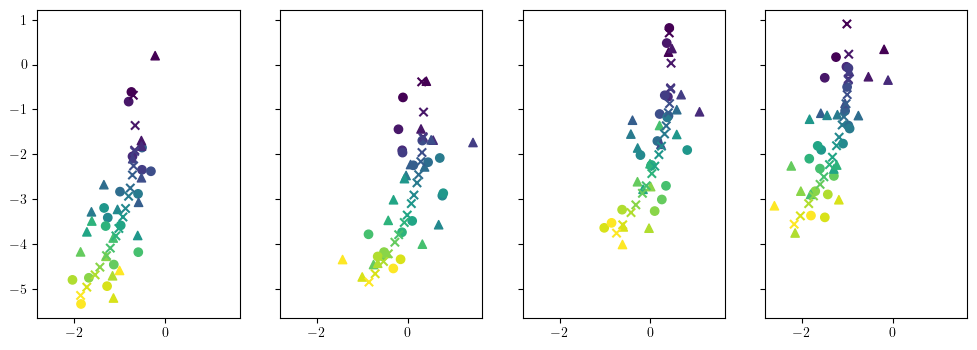

[[-1.93509429 -4.9690201 ]
 [-1.07073746 -4.45721201]
 [-0.42760052 -3.32954659]
 [-3.76847634 -1.94104806]]
[[-2.25446651 -5.32027566]
 [-1.36724301 -4.97342867]
 [-1.35575607 -4.12010771]
 [-4.40507079 -2.1094925 ]]


In [4]:
def distance(xy,p1,p2):
    return (p1-p2-xy[:,None]).ravel()

fig,ax = plt.subplots(1,4,figsize=(12,4),sharex=True,sharey=True)
for i in range(4):
    p1 = np.empty((2,18))
    p2 = np.empty((2,18))
    p1[0] = fiber_pos_fit[:,2*i]
    p1[1] = fiber_pos_fit[:,2*i+1]
    p2[0] = -fiber_pos_sc[:,2*i]
    p2[1] = -fiber_pos_sc[:,2*i+1]
    x0 = np.array([0,0])
    res = least_squares(distance, x0, args=(p1, p2))
    print(res.x)
    
    ax[i].scatter(-fiber_pos_sc[:,2*i]+res.x[0],-fiber_pos_sc[:,2*i+1]+res.x[1],marker='o',c=np.arange(18))
    ax[i].scatter(fiber_pos_fit[:,2*i],fiber_pos_fit[:,2*i+1],marker='^',c=np.arange(18))
    #ax[i].scatter(-fiber_pos_ft[:,2*i]+fiber_cor_ft[i,0],-fiber_pos_ft[:,2*i+1]+fiber_cor_ft[i,1],marker='x',c=np.arange(18))
for i in range(4):
    p1 = np.empty((2,18))
    p2 = np.empty((2,18))
    p1[0] = fiber_pos_fit[:,2*i]
    p1[1] = fiber_pos_fit[:,2*i+1]
    p2[0] = -fiber_pos_ft[:,2*i]
    p2[1] = -fiber_pos_ft[:,2*i+1]
    x0 = np.array([0,0])
    res = least_squares(distance, x0, args=(p1, p2))
    print(res.x)
    
    ax[i].scatter(-fiber_pos_ft[:,2*i]+res.x[0],-fiber_pos_ft[:,2*i+1]+res.x[1],marker='x',c=np.arange(18))
plt.show()

print(fiber_cor+fiber_cor_fit)
print(fiber_cor_ft+fiber_cor_fit)

In [5]:
def adjust_color(color, factor):
    """Brighten (factor > 1) or darken (factor < 1) a color"""
    color = np.array(to_rgb(color))
    if factor > 1:
        return np.clip(color + (1 - color) * (factor - 1), 0, 1)
    else:
        return np.clip(color * factor, 0, 1)

def bin_spectrum(wl_in, flux_in, wl_out):
    """
    Bin a spectrum by integrating flux within the wavelength bins.

    Parameters
    ----------
    wl_in : ndarray
        Original wavelength array (must be sorted and strictly increasing).
    flux_in : ndarray
        Corresponding flux values.
    wl_out : ndarray
        New wavelength bin centers (must be sorted).

    Returns
    -------
    flux_out : ndarray
        Flux values integrated over each bin in wl_out.
    """
    wl_in = np.asarray(wl_in)
    flux_in = np.asarray(flux_in)
    wl_out = np.asarray(wl_out)

    # Define bin edges from bin centers
    wl_edges = np.zeros(len(wl_out) + 1)
    wl_edges[1:-1] = 0.5 * (wl_out[1:] + wl_out[:-1])
    wl_edges[0] = wl_out[0] - (wl_out[1] - wl_out[0]) / 2
    wl_edges[-1] = wl_out[-1] + (wl_out[-1] - wl_out[-2]) / 2

    # Compute cumulative integral
    cum_flux = np.cumsum(np.concatenate([[0], np.diff(wl_in) * (flux_in[:-1] + flux_in[1:]) / 2]))
    cum_flux_interp = np.interp(wl_edges, wl_in, cum_flux, left=0, right=cum_flux[-1])

    # Bin-integrated flux
    flux_binned = np.diff(cum_flux_interp) / np.diff(wl_edges)

    return flux_binned

In [6]:
root_std = "/home/sauter/PhD/SIMTERFERE/Wavefronts/"

all_files_std = os.listdir(root_std)
files_std = []
for file in all_files_std:
    files_std.append(file)
files_std.sort()

In [7]:
root = "/home/sauter/PhD/beta Pic/astroreduced_stdpipe/astroreduced_stdpipe/"

all_files = os.listdir(root)
files = []
for file in all_files:
    if "ASTROREDUCED" in file and "BetaPic" in file:
        files.append(file)
files.sort()

vis = np.empty((18,16,6,1628),dtype=np.complex128)
vis_err = np.empty((18,16,6,1628),dtype=np.complex128)
flux = np.empty((18,16,4,1628))
vis_ft = np.empty((18,16,6,6),dtype=np.complex128)
flux_err = np.empty((18,16,4,1628))

AM = []
WS = []
Temp = []
PWV = []
Theta0 = []
Seeing = []
Tau0 = []
Pressure = []
Humid = []
ALT = []
Time = []
cx = []
cy = []

ind = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
baseline_labels = ["34", "24", "14", "23", "13", "12"]
j = 0
for file in files:
    if fits.open(root+file)[0].header["HIERARCH ESO DET2 SEQ1 DIT"] == 3:

        vis[j] = fits.open(root+file)[5].data["VISDATA"].reshape(16,6,1628)
        vis_err[j] = fits.open(root+file)[5].data["VISERR"].reshape(16,6,1628)
        vis_ft[j] = fits.open(root+file)[5].data["VISDATA_FT"].reshape(16,6,6)
        flux[j] = fits.open(root+file)[7].data["FLUX"].reshape(16,4,1628)
        flux_err[j] = fits.open(root+file)[7].data["FLUXERR"].reshape(16,4,1628)
        wave = fits.open(root+file)[1].data["EFF_WAVE"]
        wave_ft = fits.open(root+file)[2].data["EFF_WAVE"]
        h = fits.open(root+file)[0].header

        print(file,(h["HIERARCH ESO ISS AIRM END"]+h["HIERARCH ESO ISS AIRM END"])/2)
        AM.append((h["HIERARCH ESO ISS AIRM END"]+h["HIERARCH ESO ISS AIRM END"])/2)
        WS.append(h["HIERARCH ESO ISS AMBI WINDSP"])
        Temp.append(h["HIERARCH ESO ISS AMBI TEMP"])
        PWV.append(0.5*(h["HIERARCH ESO ISS AMBI IWV START"]+h["HIERARCH ESO ISS AMBI IWV END"]))
        Theta0.append(0.5*(h["HIERARCH ESO ISS AMBI THETA0 START"]+h["HIERARCH ESO ISS AMBI THETA0 END"]))
        Seeing.append(0.5*(h["HIERARCH ESO ISS AMBI FWHM START"]+h["HIERARCH ESO ISS AMBI FWHM END"]))
        Tau0.append(0.5*(h["HIERARCH ESO ISS AMBI TAU0 START"]+h["HIERARCH ESO ISS AMBI TAU0 END"]))
        Pressure.append(h["HIERARCH ESO ISS AMBI PRES"])
        Humid.append(h["HIERARCH ESO ISS AMBI RHUM"])
        ALT.append([h["HIERARCH ESO ISS ALT"]])
        Time.append(h['MJD-OBS'])
        cx.append(h["HIERARCH ESO ACQ ARD CORX"])
        cy.append(h["HIERARCH ESO ACQ ARD CORY"])
        j += 1

vis_flux = np.empty((18,16,6,1628))
for i in range(6):
    vis_flux[:,:,i] = np.sqrt(flux[:,:,ind[i][0]]*flux[:,:,ind[i][1]])

SCI_BetaPicb_ONAXIS_2024-12-20T00:51:39_ASTROREDUCED.fits 1.532
SCI_BetaPicb_ONAXIS_2024-12-20T01:31:43_ASTROREDUCED.fits 1.372
SCI_BetaPicb_ONAXIS_2024-12-20T02:10:03_ASTROREDUCED.fits 1.265
SCI_BetaPicb_ONAXIS_2024-12-20T02:12:03_ASTROREDUCED.fits 1.261
SCI_BetaPicb_ONAXIS_2024-12-20T02:37:37_ASTROREDUCED.fits 1.21
SCI_BetaPicb_ONAXIS_2024-12-20T02:54:29_ASTROREDUCED.fits 1.183
SCI_BetaPicb_ONAXIS_2024-12-20T03:20:01_ASTROREDUCED.fits 1.152
SCI_BetaPicb_ONAXIS_2024-12-20T03:36:40_ASTROREDUCED.fits 1.137
SCI_BetaPicb_ONAXIS_2024-12-20T04:02:24_ASTROREDUCED.fits 1.122
SCI_BetaPicb_ONAXIS_2024-12-20T04:20:49_ASTROREDUCED.fits 1.117
SCI_BetaPicb_ONAXIS_2024-12-20T04:46:11_ASTROREDUCED.fits 1.118
SCI_BetaPicb_ONAXIS_2024-12-20T05:02:38_ASTROREDUCED.fits 1.123
SCI_BetaPicb_ONAXIS_2024-12-20T05:29:57_ASTROREDUCED.fits 1.14
SCI_BetaPicb_ONAXIS_2024-12-20T05:46:35_ASTROREDUCED.fits 1.156
SCI_BetaPicb_ONAXIS_2024-12-20T06:12:01_ASTROREDUCED.fits 1.189
SCI_BetaPicb_ONAXIS_2024-12-20T06:28:32_AS

In [8]:
N = 18

vis_sim = np.empty((N,16,6,1628))
flux_sim = np.empty((N,16,4,1628))
vis_ft_sim = np.empty((N,16,6,6))

ind = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

root_sim = "/home/sauter/PhD/SIMTERFERE/Visibility_Simulation_Offset_Tel/"
all_files_sim = os.listdir(root_sim)
all_files_sim.sort()
for i in range(N):
    for j in range(16):
        sc = np.loadtxt(root_sim+all_files_sim[i]+f'/sc{j}.txt',dtype=np.complex128)
        flux_sim[i,j] = np.real(sc[:4])
        vis_sim[i,j] = np.abs(sc[4:10])

        ft = np.loadtxt(root_sim+all_files_sim[i]+f'/ft{j}.txt',dtype=np.complex128)
        vis_ft_sim[i,j] = np.abs(ft[4:10])

vis_sim[:,:,:,1504] =  (vis_sim[:,:,:,1503]+vis_sim[:,:,:,1505])/2
flux_sim[:,:,:,1504] =  (flux_sim[:,:,:,1503]+flux_sim[:,:,:,1505])/2

vis_sim[:,:,:,356] =  (vis_sim[:,:,:,355]+vis_sim[:,:,:,357])/2
flux_sim[:,:,:,356] =  (flux_sim[:,:,:,355]+flux_sim[:,:,:,357])/2

vis_flux_sim = np.empty((N,16,6,1628))
for i in range(6):
    vis_flux_sim[:,:,i] = np.sqrt(flux_sim[:,:,ind[i][0]]*flux_sim[:,:,ind[i][1]])

In [9]:
vis_sim_align = np.empty((N,16,6,1628))
flux_sim_align = np.empty((N,16,4,1628))
vis_ft_sim_align = np.empty((N,16,6,6))

root_sim = "/home/sauter/PhD/SIMTERFERE/Visibility_Simulation/"
all_files_sim = os.listdir(root_sim)
all_files_sim.sort()
for i in range(N):
    for j in range(16):
        sc = np.loadtxt(root_sim+all_files_sim[i]+f'/sc{j}.txt',dtype=np.complex128)
        flux_sim_align[i,j] = np.real(sc[:4])
        vis_sim_align[i,j] = np.abs(sc[4:10])

        ft = np.loadtxt(root_sim+all_files_sim[i]+f'/ft{j}.txt',dtype=np.complex128)
        vis_ft_sim_align[i,j] = np.abs(ft[4:10])

vis_sim_align[:,:,:,1504] =  (vis_sim_align[:,:,:,1503]+vis_sim_align[:,:,:,1505])/2
flux_sim_align[:,:,:,1504] =  (flux_sim_align[:,:,:,1503]+flux_sim_align[:,:,:,1505])/2

vis_sim_align[:,:,:,356] =  (vis_sim_align[:,:,:,355]+vis_sim_align[:,:,:,357])/2
flux_sim_align[:,:,:,356] =  (flux_sim_align[:,:,:,355]+flux_sim_align[:,:,:,357])/2

vis_flux_sim_align = np.empty((N,16,6,1628))
for i in range(6):
    vis_flux_sim_align[:,:,i] = np.sqrt(flux_sim_align[:,:,ind[i][0]]*flux_sim_align[:,:,ind[i][1]])

/tmp/ipykernel_1094778/1674249924.py:63: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.05,top=0.97,left=0.1,right=0.96)


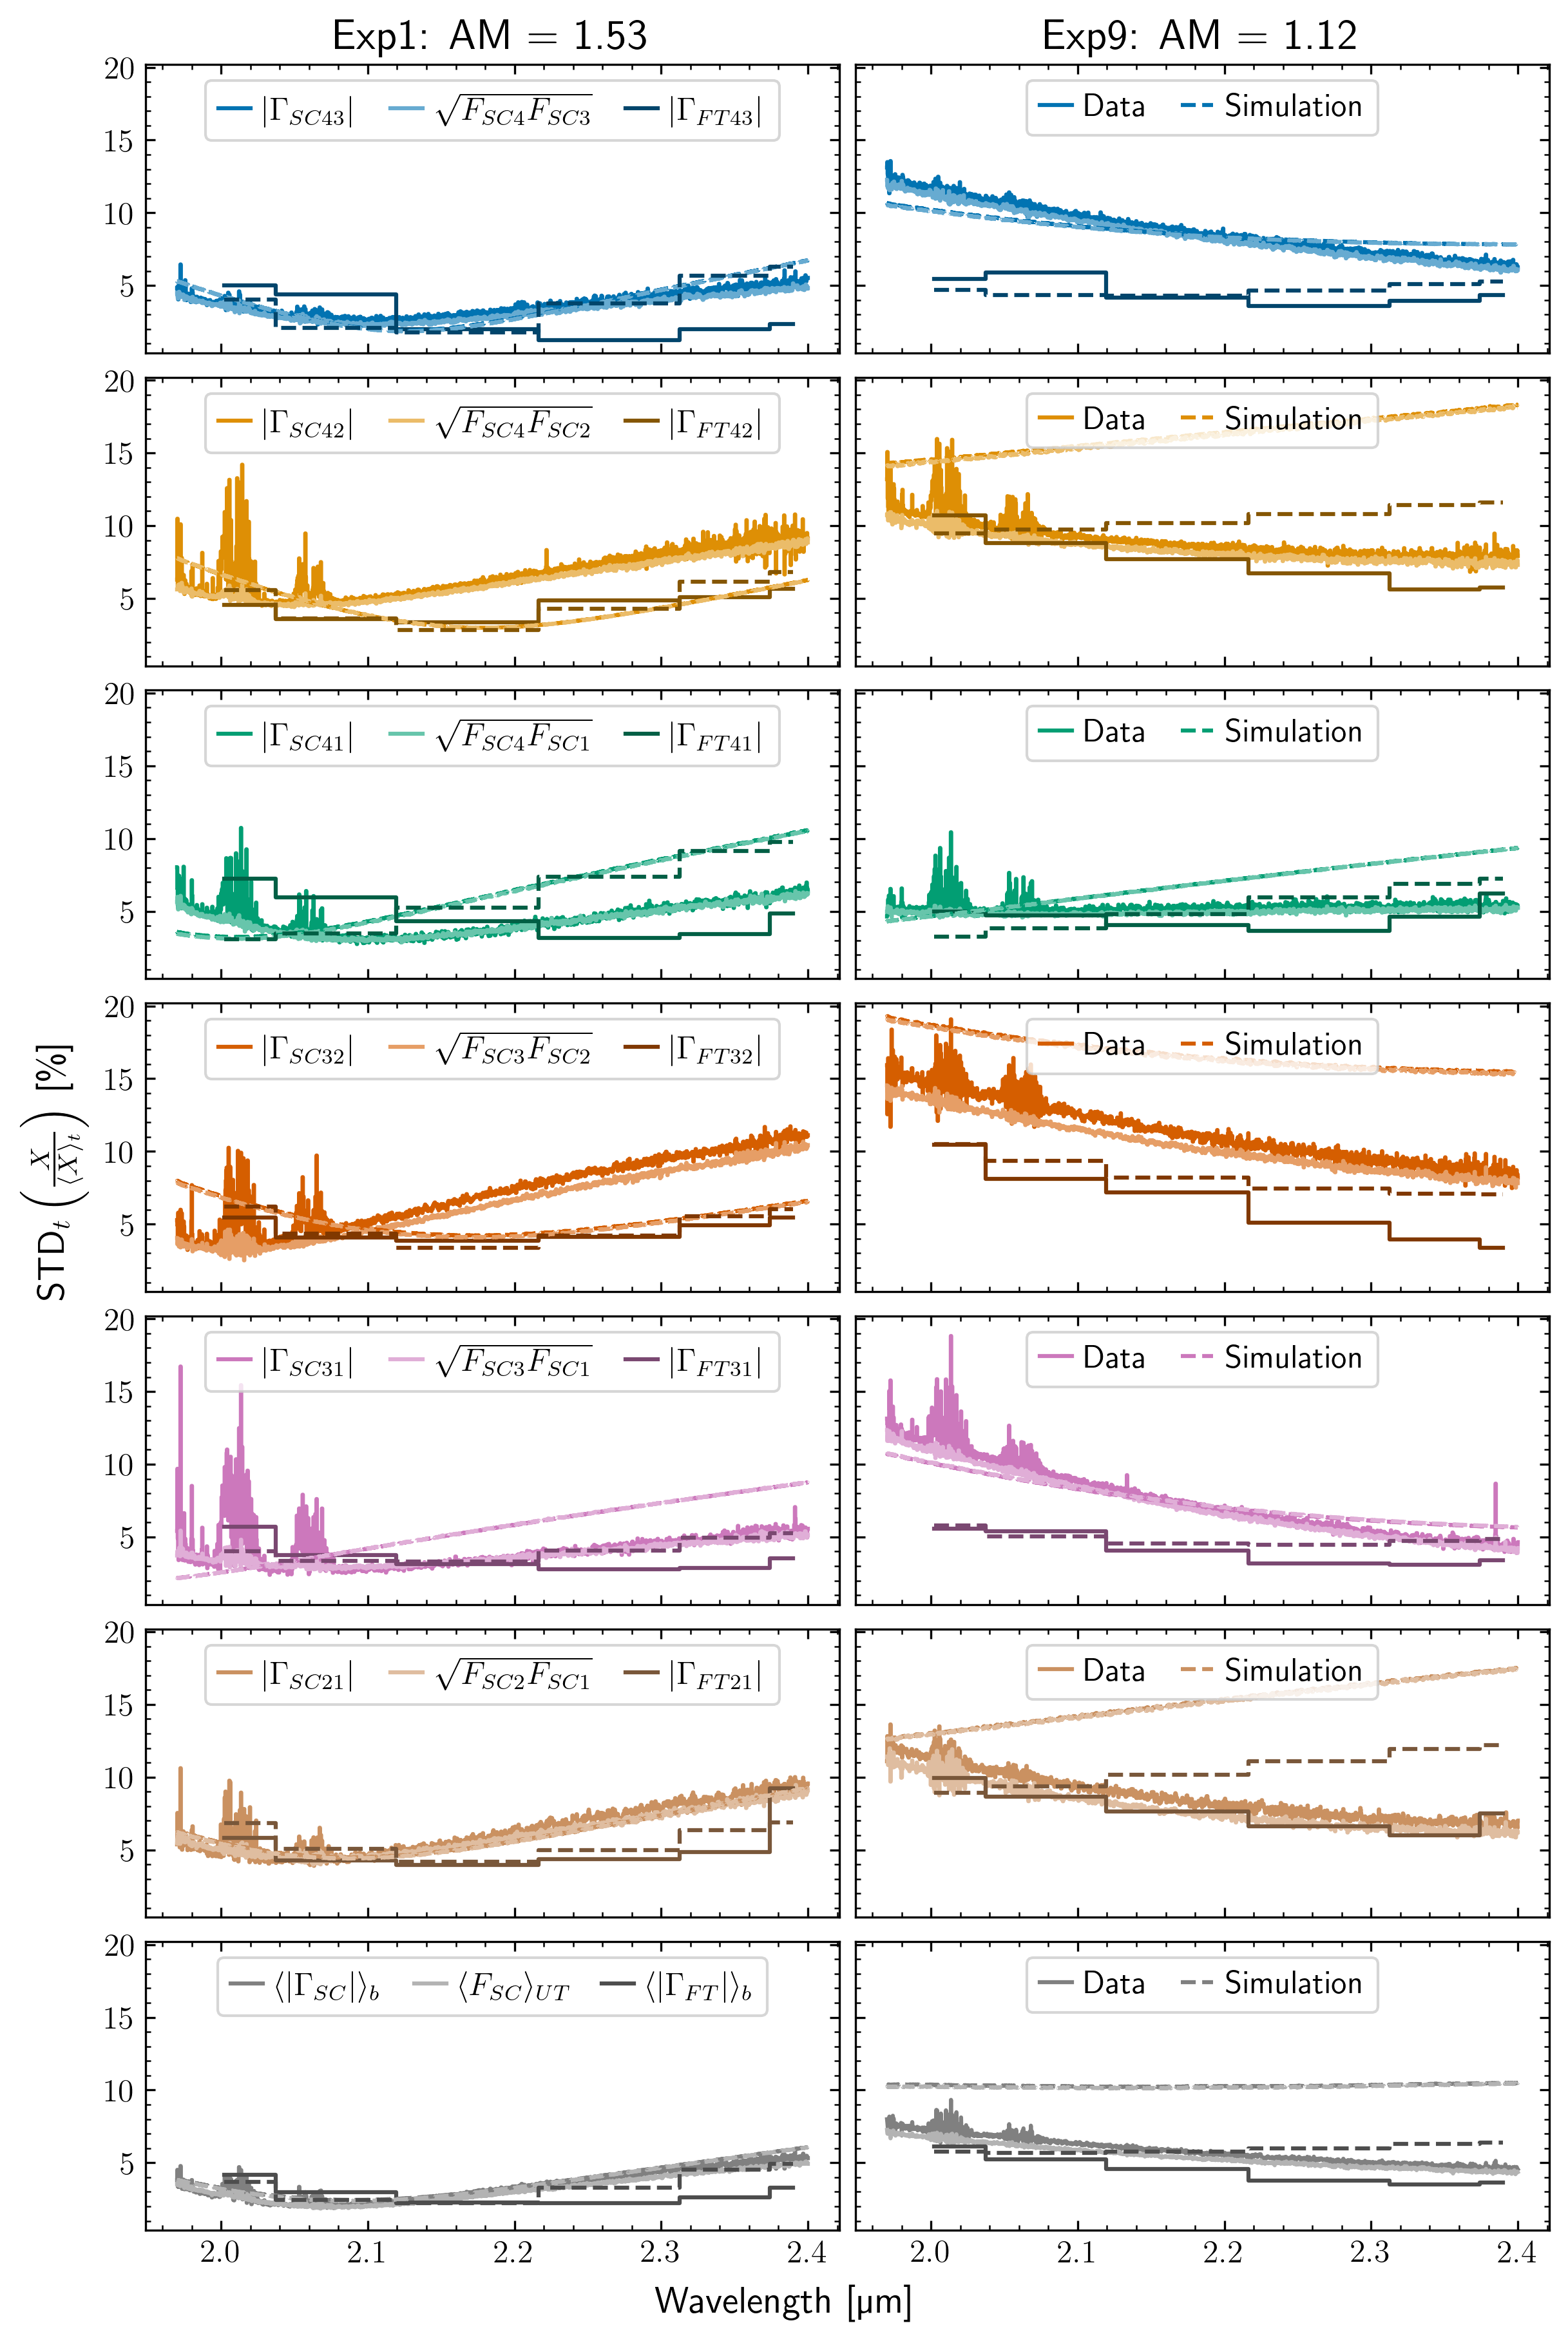

In [10]:
col = sns.color_palette('colorblind')

bll = ["43","42","41","32","31","21"]
indi = [(4,3),(4,2),(4,1),(3,2),(3,1),(2,1)]

J = [0,8]

fig,ax = plt.subplots(7,2,dpi=300,figsize=(8,12),sharey=True,sharex=True,constrained_layout=True)
for i in range(6):
    for j in range(2):
        #ax[i].set_title(bl_labels[i])

        base = col[i]
        light = adjust_color(base, 1.4)
        dark  = adjust_color(base, 0.6)
        if j == 0:
            ax[i][j].plot(wave*1e6,100*np.std(np.abs(vis[J[j]])[:,i]/np.mean(np.abs(vis[J[j]])[:,i],axis=0)[None,:],axis=0),color=base,ds='steps-mid',label=f'$|\Gamma_{{SC{bll[i]}}}|$')
            ax[i][j].plot(wave*1e6,100*np.std(np.abs(vis_flux[J[j]])[:,i]/np.mean(np.abs(vis_flux[J[j]])[:,i],axis=0)[None,:],axis=0),color=light,ds='steps-mid',label = f'$\sqrt{{F_{{SC{indi[i][0]}}}F_{{SC{indi[i][1]}}}}}$')
            ax[i][j].plot(wave_ft*1e6,100*np.std(np.abs(vis_ft[J[j]])[:,i]/np.mean(np.abs(vis_ft[J[j]])[:,i],axis=0)[None,:],axis=0),color=dark,ds='steps-mid',label=f'$|\Gamma_{{FT{bll[i]}}}|$')
            
            ax[i][j].plot(wave*1e6,100*np.std(np.abs(vis_sim[J[j]])[:,i]/np.mean(np.abs(vis_sim[J[j]])[:,i],axis=0)[None,:],axis=0),'--',color=base,ds='steps-mid')
            ax[i][j].plot(wave*1e6,100*np.std(np.abs(vis_flux_sim[J[j]])[:,i]/np.mean(np.abs(vis_flux_sim[J[j]])[:,i],axis=0)[None,:],axis=0),'--',color=light,ds='steps-mid')
            ax[i][j].plot(wave_ft*1e6,100*np.std(np.abs(vis_ft_sim[J[j]])[:,i]/np.mean(np.abs(vis_ft_sim[J[j]])[:,i],axis=0)[None,:],axis=0),'--',color=dark,ds='steps-mid')
        if j == 1:
            ax[i][j].plot(wave*1e6,100*np.std(np.abs(vis[J[j]])[:,i]/np.mean(np.abs(vis[J[j]])[:,i],axis=0)[None,:],axis=0),color=base,ds='steps-mid',label='Data')
            ax[i][j].plot(wave*1e6,100*np.std(np.abs(vis_flux[J[j]])[:,i]/np.mean(np.abs(vis_flux[J[j]])[:,i],axis=0)[None,:],axis=0),color=light,ds='steps-mid')
            ax[i][j].plot(wave_ft*1e6,100*np.std(np.abs(vis_ft[J[j]])[:,i]/np.mean(np.abs(vis_ft[J[j]])[:,i],axis=0)[None,:],axis=0),color=dark,ds='steps-mid')
            
            ax[i][j].plot(wave*1e6,100*np.std(np.abs(vis_sim[J[j]])[:,i]/np.mean(np.abs(vis_sim[J[j]])[:,i],axis=0)[None,:],axis=0),'--',color=base,ds='steps-mid',label='Simulation')
            ax[i][j].plot(wave*1e6,100*np.std(np.abs(vis_flux_sim[J[j]])[:,i]/np.mean(np.abs(vis_flux_sim[J[j]])[:,i],axis=0)[None,:],axis=0),'--',color=light,ds='steps-mid',)
            ax[i][j].plot(wave_ft*1e6,100*np.std(np.abs(vis_ft_sim[J[j]])[:,i]/np.mean(np.abs(vis_ft_sim[J[j]])[:,i],axis=0)[None,:],axis=0),'--',color=dark,ds='steps-mid')
for j in range(2):
    base = 'gray'
    light = adjust_color(base, 1.4)
    dark  = adjust_color(base, 0.6)
    if j == 0:
        ax[6][j].plot(wave*1e6,100*np.std(np.mean(np.abs(vis[J[j]]),axis=1)/np.mean(np.abs(vis[J[j]]),axis=(0,1))[None,:],axis=0),color=base,label=r'$\langle |\Gamma_{SC}| \rangle_{b}$',ds='steps-mid')
        ax[6][j].plot(wave*1e6,100*np.std(np.mean(np.abs(vis_flux[J[j]]),axis=1)/np.mean(np.abs(vis_flux[J[j]]),axis=(0,1))[None,:],axis=0),color=light,label=r'$\langle F_{SC} \rangle_{UT}$',ds='steps-mid')
        ax[6][j].plot(wave_ft*1e6,100*np.std(np.mean(np.abs(vis_ft[J[j]]),axis=1)/np.mean(np.abs(vis_ft[J[j]]),axis=(0,1))[None,:],axis=0),color=dark,label=r'$\langle |\Gamma_{FT}| \rangle_{b}$',ds='steps-mid')
        
        ax[6][j].plot(wave*1e6,100*np.std(np.mean(np.abs(vis_sim[J[j]]),axis=1)/np.mean(np.abs(vis_sim[J[j]]),axis=(0,1))[None,:],axis=0),'--',color=base,ds='steps-mid')
        ax[6][j].plot(wave*1e6,100*np.std(np.mean(np.abs(vis_flux_sim[J[j]]),axis=1)/np.mean(np.abs(vis_flux_sim[J[j]]),axis=(0,1))[None,:],axis=0),'--',color=light,ds='steps-mid')
        ax[6][j].plot(wave_ft*1e6,100*np.std(np.mean(np.abs(vis_ft_sim[J[j]]),axis=1)/np.mean(np.abs(vis_ft_sim[J[j]]),axis=(0,1))[None,:],axis=0),'--',color=dark,ds='steps-mid')

    if j == 1:
        ax[6][j].plot(wave*1e6,100*np.std(np.mean(np.abs(vis[J[j]]),axis=1)/np.mean(np.abs(vis[J[j]]),axis=(0,1))[None,:],axis=0),color=base,label='Data')
        ax[6][j].plot(wave*1e6,100*np.std(np.mean(np.abs(vis_flux[J[j]]),axis=1)/np.mean(np.abs(vis_flux[J[j]]),axis=(0,1))[None,:],axis=0),color=light)
        ax[6][j].plot(wave_ft*1e6,100*np.std(np.mean(np.abs(vis_ft[J[j]]),axis=1)/np.mean(np.abs(vis_ft[J[j]]),axis=(0,1))[None,:],axis=0),color=dark,ds='steps-mid')
        
        ax[6][j].plot(wave*1e6,100*np.std(np.mean(np.abs(vis_sim[J[j]]),axis=1)/np.mean(np.abs(vis_sim[J[j]]),axis=(0,1))[None,:],axis=0),'--',color=base,ds='steps-mid',label='Simulation')
        ax[6][j].plot(wave*1e6,100*np.std(np.mean(np.abs(vis_flux_sim[J[j]]),axis=1)/np.mean(np.abs(vis_flux_sim[J[j]]),axis=(0,1))[None,:],axis=0),'--',color=light,ds='steps-mid')
        ax[6][j].plot(wave_ft*1e6,100*np.std(np.mean(np.abs(vis_ft_sim[J[j]]),axis=1)/np.mean(np.abs(vis_ft_sim[J[j]]),axis=(0,1))[None,:],axis=0),'--',color=dark,ds='steps-mid')

    ax[0][j].set_title(f'Exp{J[j]+1}: AM = {AM[J[j]]:.2f}',fontsize=16)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i][j].legend(loc='upper center',fontsize=12,ncols=3,handlelength=1.0,handletextpad=0.4,columnspacing=1.0)
        ax[i][j].tick_params(axis='both', which='both', top=True, right=True, direction='in',labelsize=12)
        ax[i][j].minorticks_on()
        
fig.supxlabel('Wavelength [µm]',fontsize=14)
fig.subplots_adjust(bottom=0.05,top=0.97,left=0.1,right=0.96)
fig.supylabel(r'$\text{STD}_t\left(\frac{X}{\langle X \rangle_t}\right)$ [\%]',fontsize=14)
#plt.tight_layout()
plt.savefig('/home/sauter/PhD/SIMTERFERE/Plots/Normalized_STD_AM_sim.pdf',bbox_inches='tight')
plt.show()

/tmp/ipykernel_1094778/919831091.py:36: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.05,top=0.97,left=0.1,right=0.96)


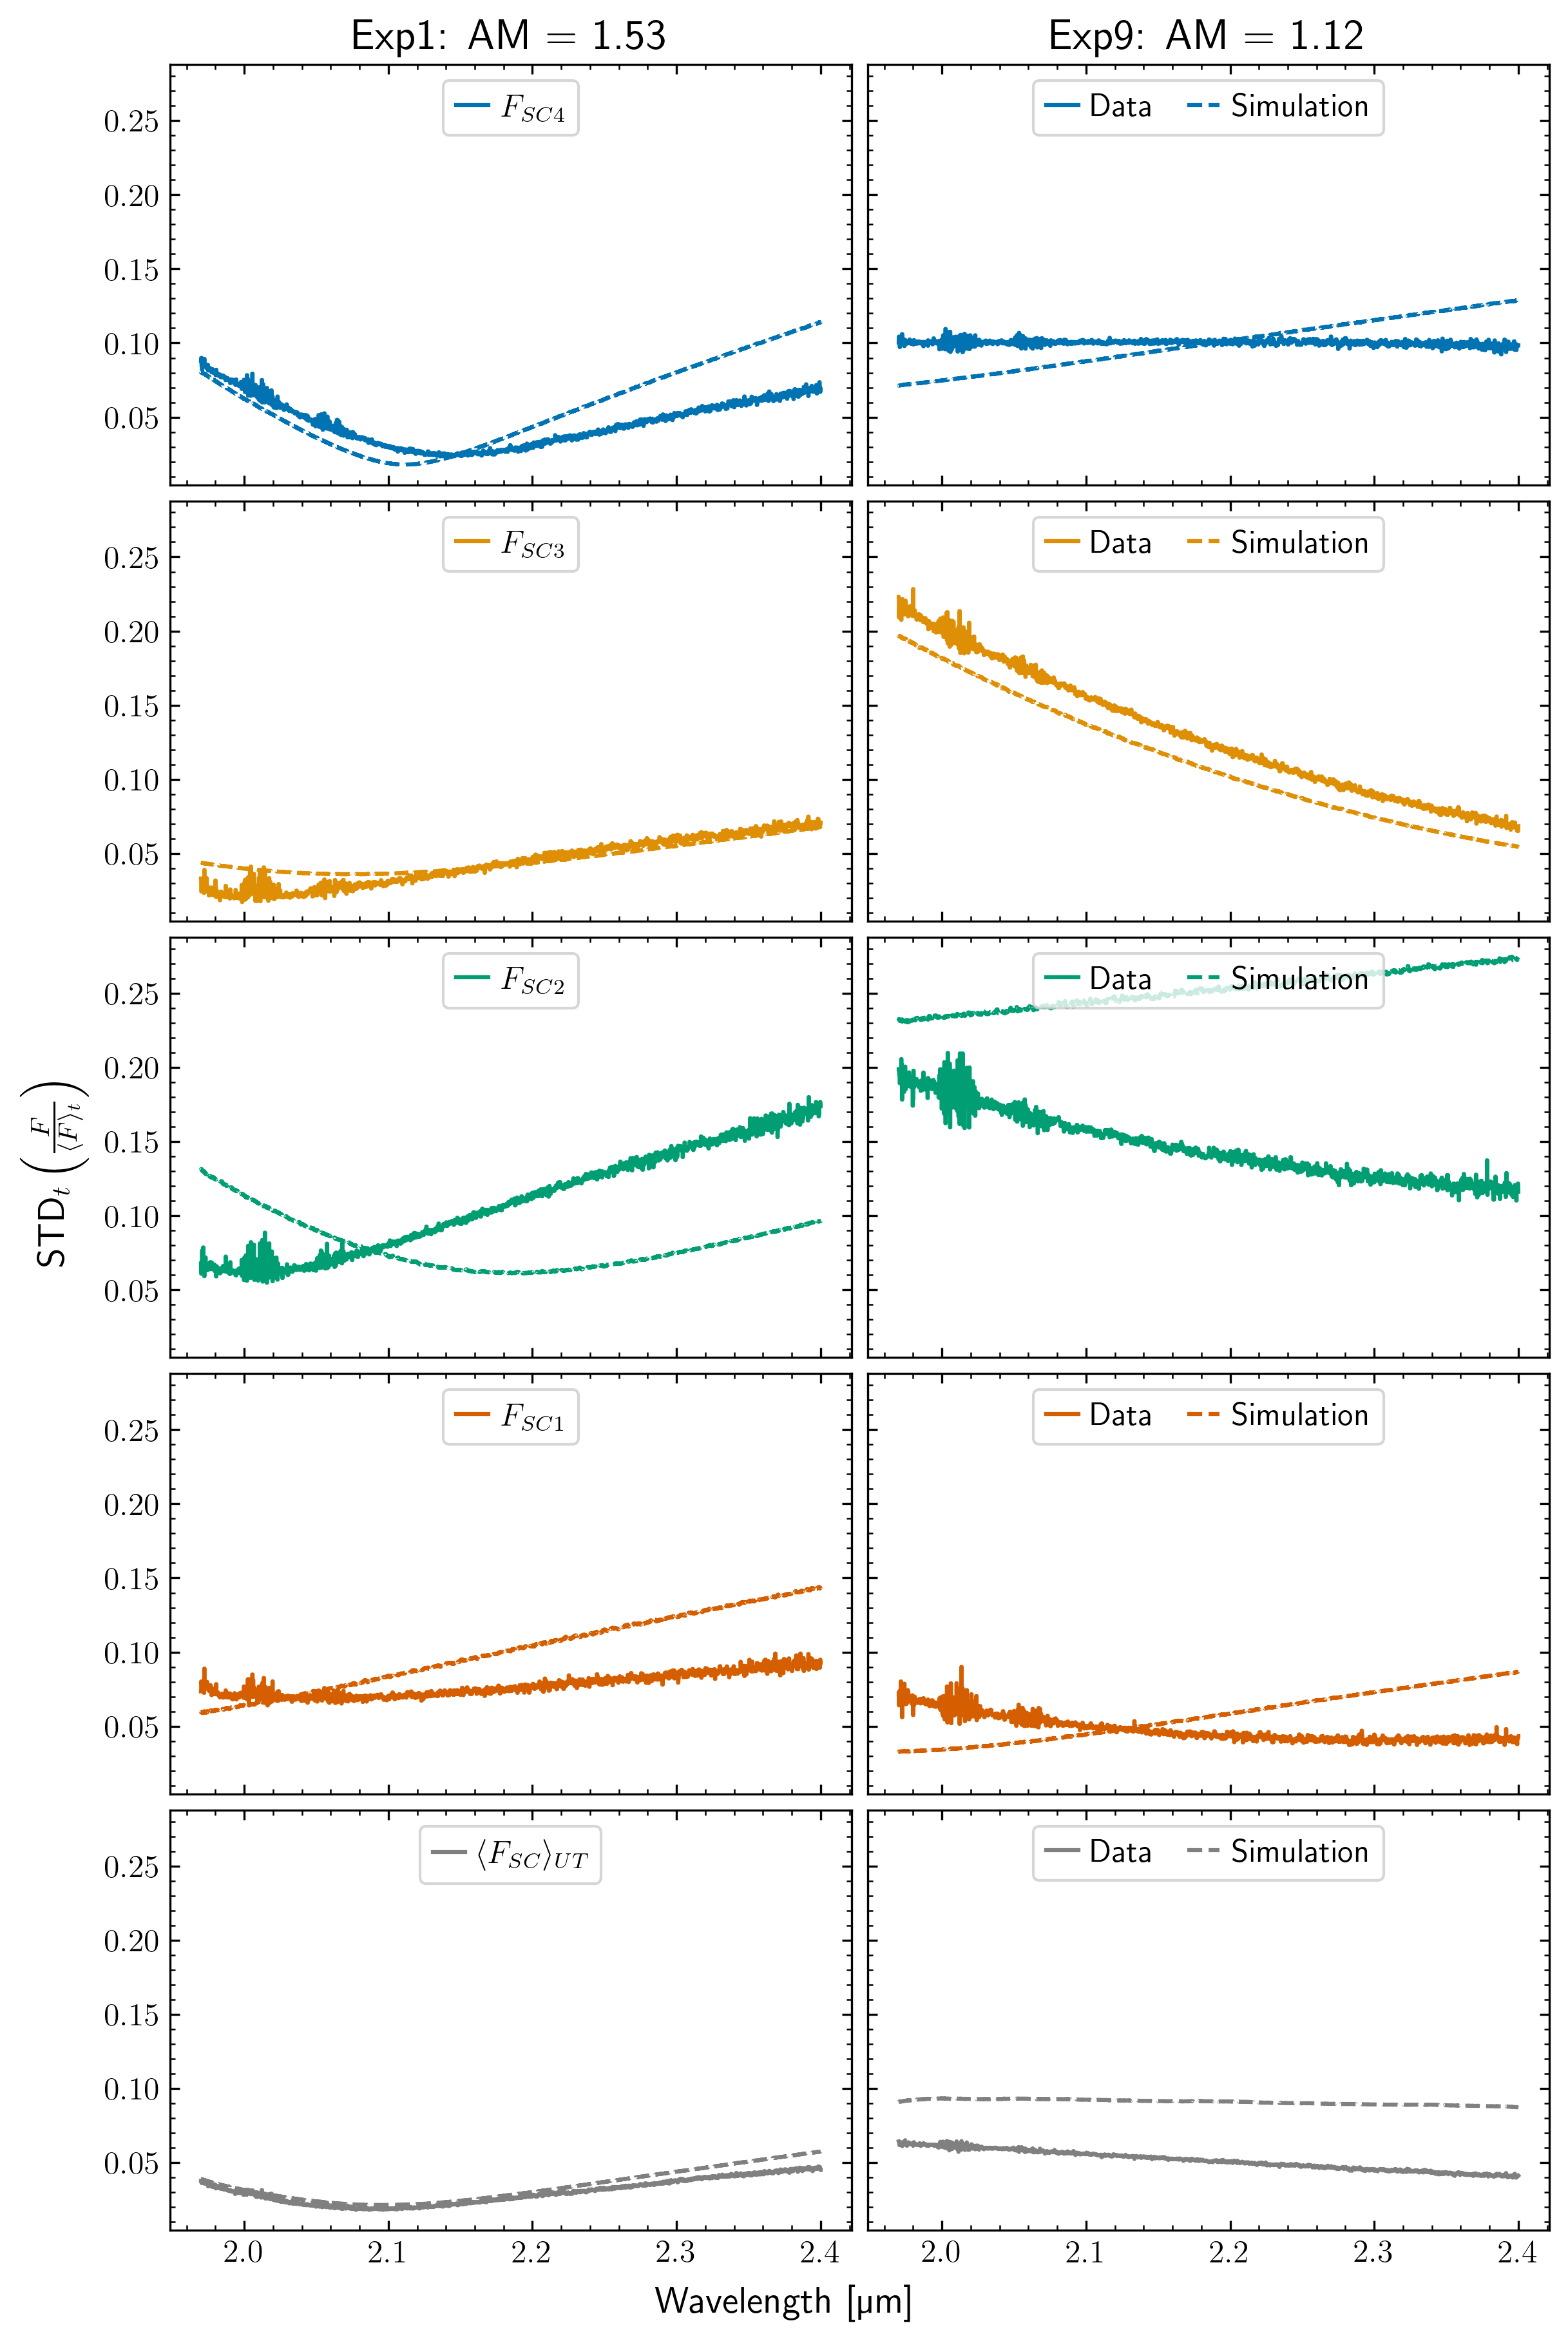

In [11]:
fig,ax = plt.subplots(5,2,dpi=300,figsize=(8,12),sharey=True,sharex=True,constrained_layout=True)
for i in range(4):
    for j in range(2):
        #ax[i].set_title(bl_labels[i])

        base = col[i]
        light = adjust_color(base, 1.4)
        dark  = adjust_color(base, 0.6)
        if j == 0:
            ax[i][j].plot(wave*1e6,np.std(np.abs(flux[J[j]])[:,i]/np.mean(np.abs(flux[J[j]])[:,i],axis=0)[None,:],axis=0),color=base,ds='steps-mid',label=f'$F_{{SC{4-i}}}$')
            ax[i][j].plot(wave*1e6,np.std(np.abs(flux_sim[J[j]])[:,i]/np.mean(np.abs(flux_sim[J[j]])[:,i],axis=0)[None,:],axis=0),'--',color=base,ds='steps-mid')
        if j == 1:
            ax[i][j].plot(wave*1e6,np.std(np.abs(flux[J[j]])[:,i]/np.mean(np.abs(flux[J[j]])[:,i],axis=0)[None,:],axis=0),color=base,ds='steps-mid',label='Data')
            ax[i][j].plot(wave*1e6,np.std(np.abs(flux_sim[J[j]])[:,i]/np.mean(np.abs(flux_sim[J[j]])[:,i],axis=0)[None,:],axis=0),'--',color=base,ds='steps-mid',label='Simulation')
for j in range(2):
    base = 'gray'
    light = adjust_color(base, 1.4)
    dark  = adjust_color(base, 0.6)
    if j == 0:
        ax[4][j].plot(wave*1e6,np.std(np.mean(np.abs(flux[J[j]]),axis=1)/np.mean(np.abs(flux[J[j]]),axis=(0,1))[None,:],axis=0),color=base,label=r'$\langle F_{SC} \rangle_{UT}$',ds='steps-mid')
        ax[4][j].plot(wave*1e6,np.std(np.mean(np.abs(flux_sim[J[j]]),axis=1)/np.mean(np.abs(flux_sim[J[j]]),axis=(0,1))[None,:],axis=0),'--',color=base,ds='steps-mid')

    if j == 1:
        ax[4][j].plot(wave*1e6,np.std(np.mean(np.abs(flux[J[j]]),axis=1)/np.mean(np.abs(flux[J[j]]),axis=(0,1))[None,:],axis=0),color=base,label='Data')
        ax[4][j].plot(wave*1e6,np.std(np.mean(np.abs(flux_sim[J[j]]),axis=1)/np.mean(np.abs(flux_sim[J[j]]),axis=(0,1))[None,:],axis=0),'--',color=base,ds='steps-mid',label='Simulation')

    ax[0][j].set_title(f'Exp{J[j]+1}: AM = {AM[J[j]]:.2f}',fontsize=16)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i][j].legend(loc='upper center',fontsize=12,ncols=3,handlelength=1.0,handletextpad=0.4,columnspacing=1.0)
        ax[i][j].tick_params(axis='both', which='both', top=True, right=True, direction='in',labelsize=12)
        ax[i][j].minorticks_on()
        
fig.supxlabel('Wavelength [µm]',fontsize=14)
fig.subplots_adjust(bottom=0.05,top=0.97,left=0.1,right=0.96)
fig.supylabel(r'$\text{STD}_t\left(\frac{F}{\langle F \rangle_t}\right)$',fontsize=14)
#plt.tight_layout()
#plt.savefig('/home/sauter/PhD/SIMTERFERE/Plots/Normalized_STD_AM_sim.pdf',bbox_inches='tight')
plt.show()

In [12]:
wavestart = 1e9*wave[0]-100
waveend = 1e9*wave[-1]+100

dw = -0.00059
modeler = Modeler()
full_ref = modeler.MakeModel(
    pressure=744.7,
    temperature=287.13,
    lowfreq=1e7/waveend,
    highfreq=1e7/wavestart,
    angle=180/np.pi*np.arccos(1/1.17),
    humidity=8.*1.3,
    co2=368.5*1.25,
    ch4=1.8*1.4,
    lat=-(24+37/60+39/3600),
    alt=2.635,
    ).toarray()

#full_ref = bin_spectrum(1e-3*full_ref[:,0]-0.0001,full_ref[:,1],wave*1e6)

full_ref = interp1d(
    1e-3*full_ref[:,0]-dw,
    gaussian_filter(full_ref[:,1],len(full_ref[:,0][(1e-3*full_ref[:,0]-dw>1.97)&(1e-3*full_ref[:,0]-dw<2.4)])/1628),
    kind="linear",
    fill_value="extrapolate"
    )(1e6*wave)


Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
30.23user 1.82system 0:32.07elapsed 99%CPU (0avgtext+0avgdata 7712maxresident)k
81072inputs+2028448outputs (35major+1079minor)pagefaults 0swaps


384


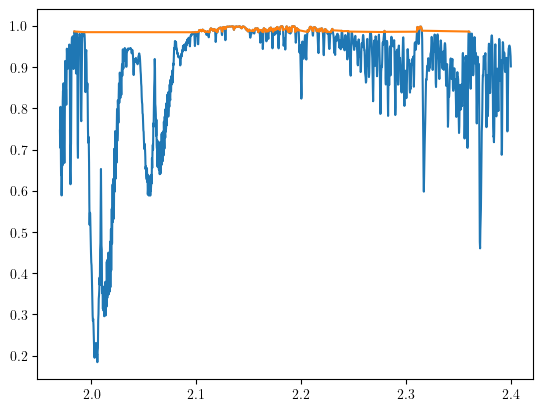

In [13]:
frac_ref = 0.985
print(len(wave[full_ref>frac_ref]))
plt.figure()
plt.plot(1e6*wave,full_ref)
plt.plot(1e6*wave[full_ref>frac_ref],full_ref[full_ref>frac_ref])
plt.show()

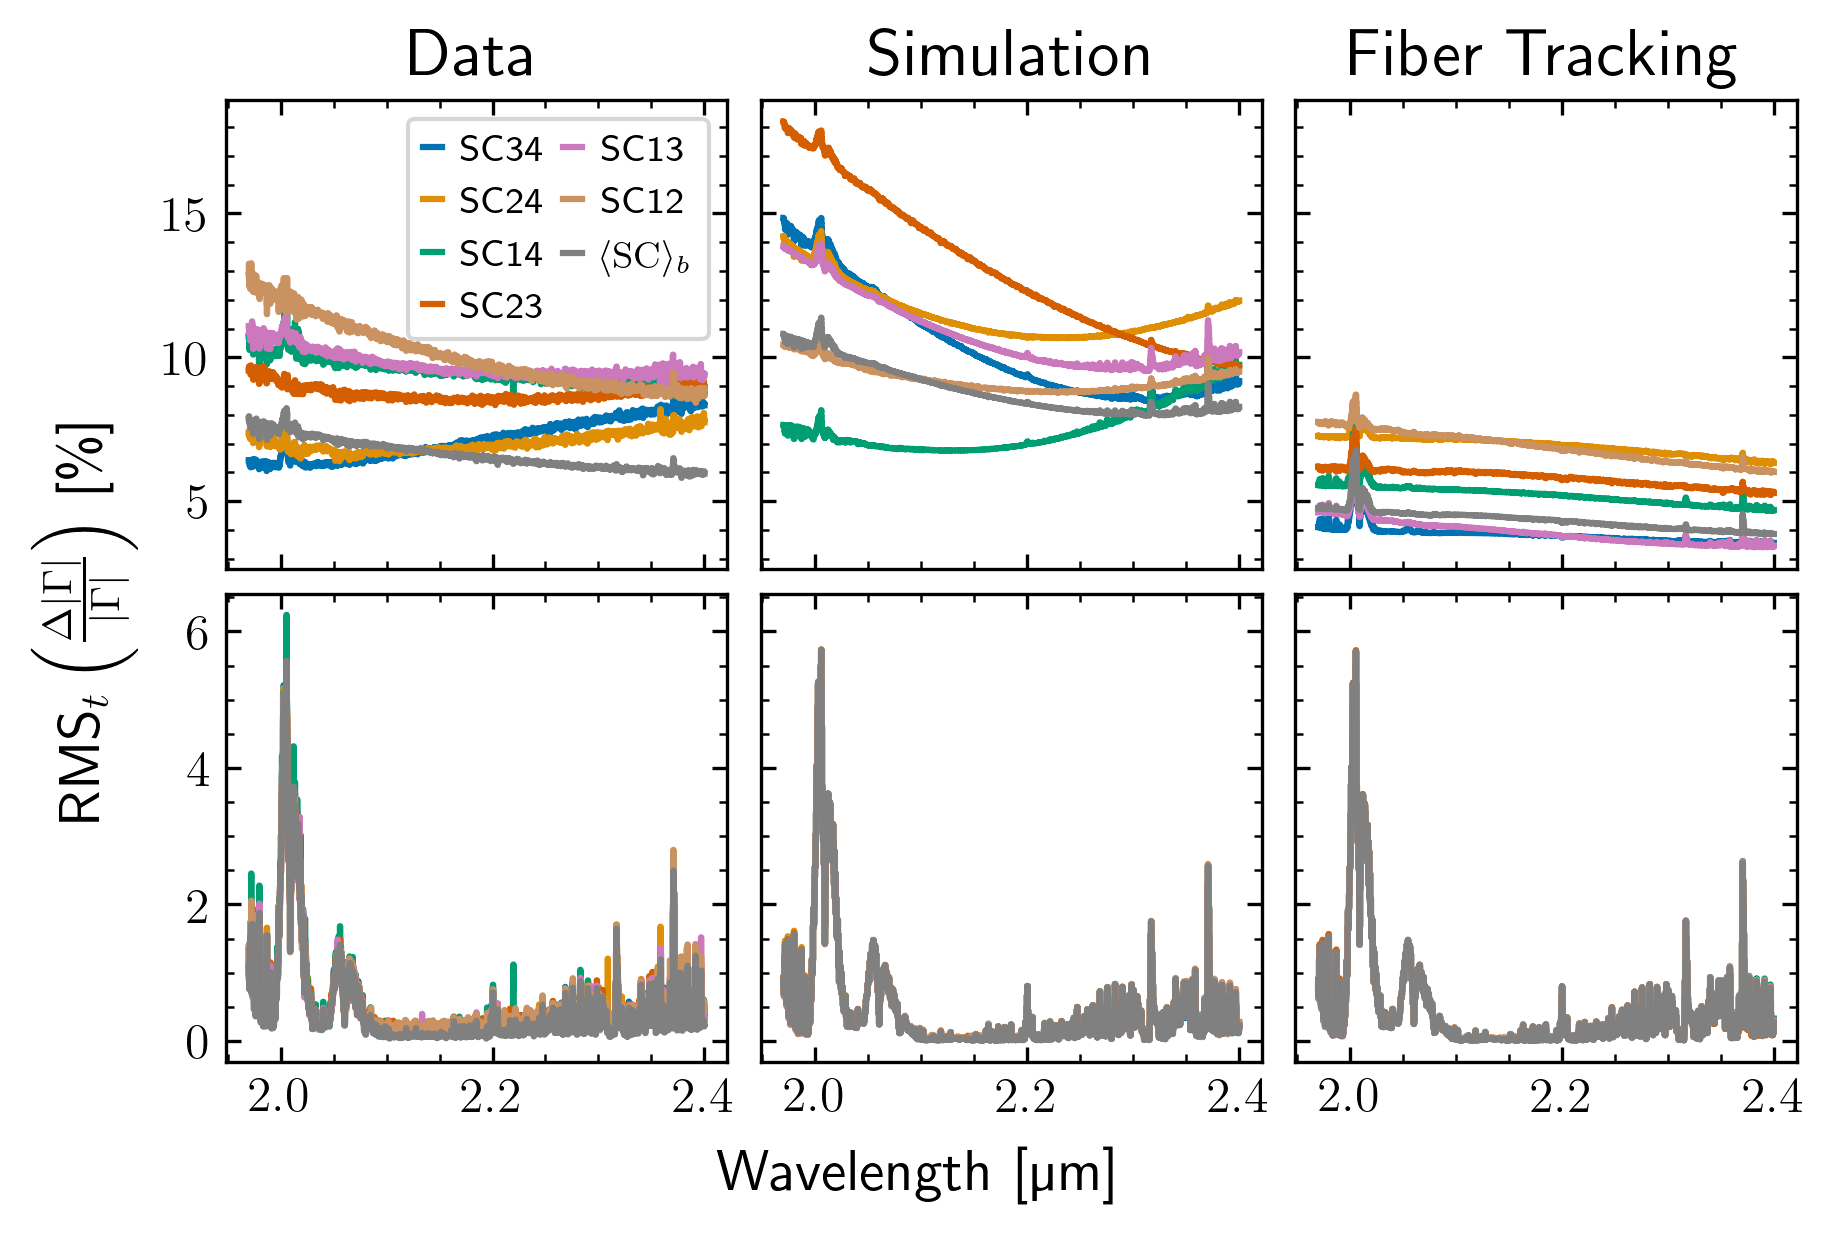

6.538425168367645 0.6741098905820495 0.4214883914684
0.21469195297120294 0.4885570547051824 0.12978212836338776


In [28]:
N1 = 0
N2 = 18
alpha = 1
vis_poly = np.empty((N2-N1,16,6,1628))
mvis = np.mean(np.abs(vis[N1:N2]),axis=(0,1))
for i in range(N2-N1):
    for j in range(16):
        for k in range(6):
            v = np.abs(vis[i+N1,j,k])/mvis[k]
            z = np.polyfit(wave[full_ref>frac_ref],v[full_ref>frac_ref],2)
            p = np.poly1d(z)(wave)
            vis_poly[i,j,k] = np.abs(vis[i+N1,j,k])/p

dvis = (np.mean(np.abs(vis),axis=1)[1+N1:N2]-np.mean(np.abs(vis),axis=1)[N1:N2-1])/np.mean(np.abs(vis),axis=1)[N1:N2-1]
dvis_poly = (np.mean(np.abs(vis_poly),axis=1)[1:]-np.mean(np.abs(vis_poly),axis=1)[:-1])/np.mean(np.abs(vis_poly),axis=1)[:-1]

dvis_m = (np.mean(np.abs(vis),axis=(1,2))[1+N1:N2]-np.mean(np.abs(vis),axis=(1,2))[N1:N2-1])/np.mean(np.abs(vis),axis=(1,2))[N1:N2-1]
dvis_poly_m = (np.mean(np.abs(vis_poly),axis=(1,2))[1:]-np.mean(np.abs(vis_poly),axis=(1,2))[:-1])/np.mean(np.abs(vis_poly),axis=(1,2))[:-1]

vis_poly_sim = np.empty((N2-N1,16,6,1628))
mvis_sim = np.mean(np.abs(vis_sim),axis=(0,1))
vis_align_poly_sim = np.empty((N2-N1,16,6,1628))
mvis_align_sim = np.mean(np.abs(vis_sim_align),axis=(0,1))
for i in range(N2-N1):
    for j in range(16):
        for k in range(6):
            v = np.abs(vis_sim[i+N1,j,k])/mvis_sim[k]
            z = np.polyfit(wave[full_ref>frac_ref],v[full_ref>frac_ref],2)
            p = np.poly1d(z)(wave)
            vis_poly_sim[i,j,k] = np.abs(vis_sim[i+N1,j,k])/p
            v = np.abs(vis_sim_align[i+N1,j,k])/mvis_align_sim[k]
            z = np.polyfit(wave[full_ref>frac_ref],v[full_ref>frac_ref],2)
            p = np.poly1d(z)(wave)
            vis_align_poly_sim[i,j,k] = np.abs(vis_sim_align[i+N1,j,k])/p

dvis_sim = (np.mean(np.abs(vis_sim),axis=1)[1+N1:N2]-np.mean(np.abs(vis_sim),axis=1)[N1:N2-1])/np.mean(np.abs(vis_sim),axis=1)[N1:N2-1]
dvis_poly_sim = (np.mean(np.abs(vis_poly_sim),axis=1)[1:]-np.mean(np.abs(vis_poly_sim),axis=1)[:-1])/np.mean(np.abs(vis_poly_sim),axis=1)[:-1]

dvis_m_sim = (np.mean(np.abs(vis_sim),axis=(1,2))[1+N1:N2]-np.mean(np.abs(vis_sim),axis=(1,2))[N1:N2-1])/np.mean(np.abs(vis_sim),axis=(1,2))[N1:N2-1]
dvis_poly_m_sim = (np.mean(np.abs(vis_poly_sim),axis=(1,2))[1:]-np.mean(np.abs(vis_poly_sim),axis=(1,2))[:-1])/np.mean(np.abs(vis_poly_sim),axis=(1,2))[:-1]

dvis_align_sim = (np.mean(np.abs(vis_sim_align),axis=1)[1+N1:N2]-np.mean(np.abs(vis_sim_align),axis=1)[N1:N2-1])/np.mean(np.abs(vis_sim_align),axis=1)[N1:N2-1]
dvis_align_poly_sim = (np.mean(np.abs(vis_align_poly_sim),axis=1)[1:]-np.mean(np.abs(vis_align_poly_sim),axis=1)[:-1])/np.mean(np.abs(vis_align_poly_sim),axis=1)[:-1]

dvis_align_m_sim = (np.mean(np.abs(vis_sim_align),axis=(1,2))[1+N1:N2]-np.mean(np.abs(vis_sim_align),axis=(1,2))[N1:N2-1])/np.mean(np.abs(vis_sim_align),axis=(1,2))[N1:N2-1]
dvis_align_poly_m_sim = (np.mean(np.abs(vis_align_poly_sim),axis=(1,2))[1:]-np.mean(np.abs(vis_align_poly_sim),axis=(1,2))[:-1])/np.mean(np.abs(vis_align_poly_sim),axis=(1,2))[:-1]

fig,ax = plt.subplots(2,3,dpi=300,figsize=(6,4),sharey='row',sharex=True,constrained_layout=True)
for i in range(6):
    base = col[i]
    light = adjust_color(base, 1.4)
    dark  = adjust_color(base, 0.6)

    ax[0][0].plot(wave*1e6,np.sqrt(np.mean((dvis[:,i])**2,axis=0))*100,color=base,ds='steps-mid',label='SC'+baseline_labels[i],alpha=alpha)
    ax[1][0].plot(wave*1e6,np.sqrt(np.mean((dvis_poly[:,i])**2,axis=0))*100,color=base,ds='steps-mid',alpha=alpha)

    ax[0][1].plot(wave*1e6,np.sqrt(np.mean((dvis_sim[:,i])**2,axis=0))*100,color=base,ds='steps-mid',alpha=alpha)
    ax[1][1].plot(wave*1e6,np.sqrt(np.mean((dvis_poly_sim[:,i])**2,axis=0))*100,color=base,ds='steps-mid',alpha=alpha)

    ax[0][2].plot(wave*1e6,np.sqrt(np.mean((dvis_align_sim[:,i])**2,axis=0))*100,color=base,ds='steps-mid',alpha=alpha)
    ax[1][2].plot(wave*1e6,np.sqrt(np.mean((dvis_align_poly_sim[:,i])**2,axis=0))*100,color=base,ds='steps-mid',alpha=alpha)

base = 'gray'
light = adjust_color(base, 1.4)
dark  = adjust_color(base, 0.6)

ax[0][0].plot(wave*1e6,np.sqrt(np.mean((dvis_m)**2,axis=0))*100,color=base,ds='steps-mid',label=r'$\langle \mathrm{SC} \rangle_b$',alpha=alpha)
ax[1][0].plot(wave*1e6,np.sqrt(np.mean((dvis_poly_m)**2,axis=0))*100,color=base,ds='steps-mid',label=r'$\langle \mathrm{SC} \rangle_b$',alpha=alpha)

ax[0][1].plot(wave*1e6,np.sqrt(np.mean((dvis_m_sim)**2,axis=0))*100,color=base,ds='steps-mid',label=r'$\langle \mathrm{SC} \rangle_b$',alpha=alpha)
ax[1][1].plot(wave*1e6,np.sqrt(np.mean((dvis_poly_m_sim)**2,axis=0))*100,color=base,ds='steps-mid',label=r'$\langle \mathrm{SC} \rangle_b$',alpha=alpha)

ax[0][2].plot(wave*1e6,np.sqrt(np.mean((dvis_align_m_sim)**2,axis=0))*100,color=base,ds='steps-mid',label=r'$\langle \mathrm{SC} \rangle_b$',alpha=alpha)
ax[1][2].plot(wave*1e6,np.sqrt(np.mean((dvis_align_poly_m_sim)**2,axis=0))*100,color=base,ds='steps-mid',label=r'$\langle \mathrm{SC} \rangle_b$',alpha=alpha)

v = np.sqrt(np.mean((dvis_m)**2,axis=0))*100
z = np.polyfit(wave[full_ref>frac_ref],v[full_ref>frac_ref],2)
p = np.poly1d(z)(wave)
#ax[0][0].plot(wave*1e6,p,'--',color='black',ds='steps-mid')
#ax[1][0].plot(wave*1e6,np.sqrt(v**2-p**2),color='black',ds='steps-mid',zorder=10)

v = np.sqrt(np.mean((dvis_m_sim)**2,axis=0))*100
z = np.polyfit(wave[full_ref>frac_ref],v[full_ref>frac_ref],2)
p = np.poly1d(z)(wave)
#ax[0][1].plot(wave*1e6,p,'--',color='black',ds='steps-mid')
#ax[1][1].plot(wave*1e6,np.sqrt(v**2-p**2),color='black',ds='steps-mid',zorder=10)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i][j].tick_params(axis='both', which='both', top=True, right=True, direction='in',labelsize=12)
        ax[i][j].minorticks_on()
ax[0][0].legend(loc='upper right',fontsize=9,ncols=2,handlelength=0.5,handletextpad=0.5,columnspacing=0.5)
ax[0][0].set_title('Data',fontsize=16)
ax[0][1].set_title('Simulation',fontsize=16)   
ax[0][2].set_title('Fiber Tracking',fontsize=16)     
fig.supxlabel('Wavelength [µm]',fontsize=14)
#fig.subplots_adjust(bottom=0.05,top=0.96,left=0.08,right=0.96)
fig.supylabel(r'$\text{RMS}_t\left(\frac{\Delta|\Gamma|}{|\Gamma|}\right)$ [\%]\,',fontsize=14)
#fig.subplots_adjust(bottom=0.08,top=0.94,left=0.12,right=0.98)
#fig.tight_layout()
#ax[1][0].set_yscale('log')
plt.savefig('/home/sauter/PhD/SIMTERFERE/Plots/RMS_visibility_diff_sim.pdf',bbox_inches='tight')
plt.show()

print(np.percentile(np.sqrt(np.mean((dvis_m)**2,axis=0))*100,50),
      np.percentile(np.sqrt(np.mean((dvis_m)**2,axis=0))*100,84)-np.percentile(np.sqrt(np.mean((dvis_m)**2,axis=0))*100,50),
      np.percentile(np.sqrt(np.mean((dvis_m)**2,axis=0))*100,50)-np.percentile(np.sqrt(np.mean((dvis_m)**2,axis=0))*100,16))

print(np.percentile(np.sqrt(np.mean((dvis_poly_m)**2,axis=0))*100,50),
      np.percentile(np.sqrt(np.mean((dvis_poly_m)**2,axis=0))*100,84)-np.percentile(np.sqrt(np.mean((dvis_poly_m)**2,axis=0))*100,50),
      np.percentile(np.sqrt(np.mean((dvis_poly_m)**2,axis=0))*100,50)-np.percentile(np.sqrt(np.mean((dvis_poly_m)**2,axis=0))*100,16))

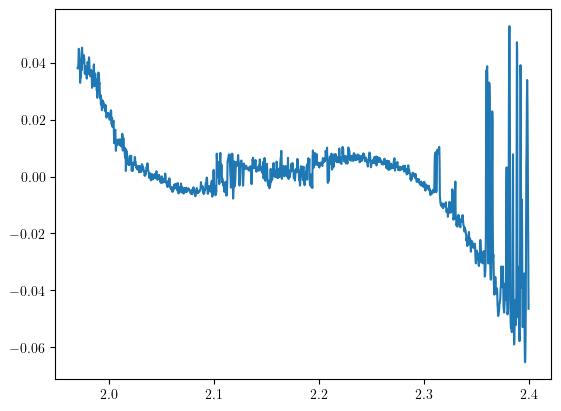

0.017127210422188628


In [32]:
plt.figure()
plt.plot(1e6*wave,np.sqrt(np.mean((dvis_poly_m_sim)**2,axis=0))*100-np.sqrt(np.mean((dvis_align_poly_m_sim)**2,axis=0))*100)
plt.show()

print(np.sqrt(np.mean((np.sqrt(np.mean((dvis_poly_m_sim)**2,axis=0))*100-np.sqrt(np.mean((dvis_align_poly_m_sim)**2,axis=0))*100)**2)))

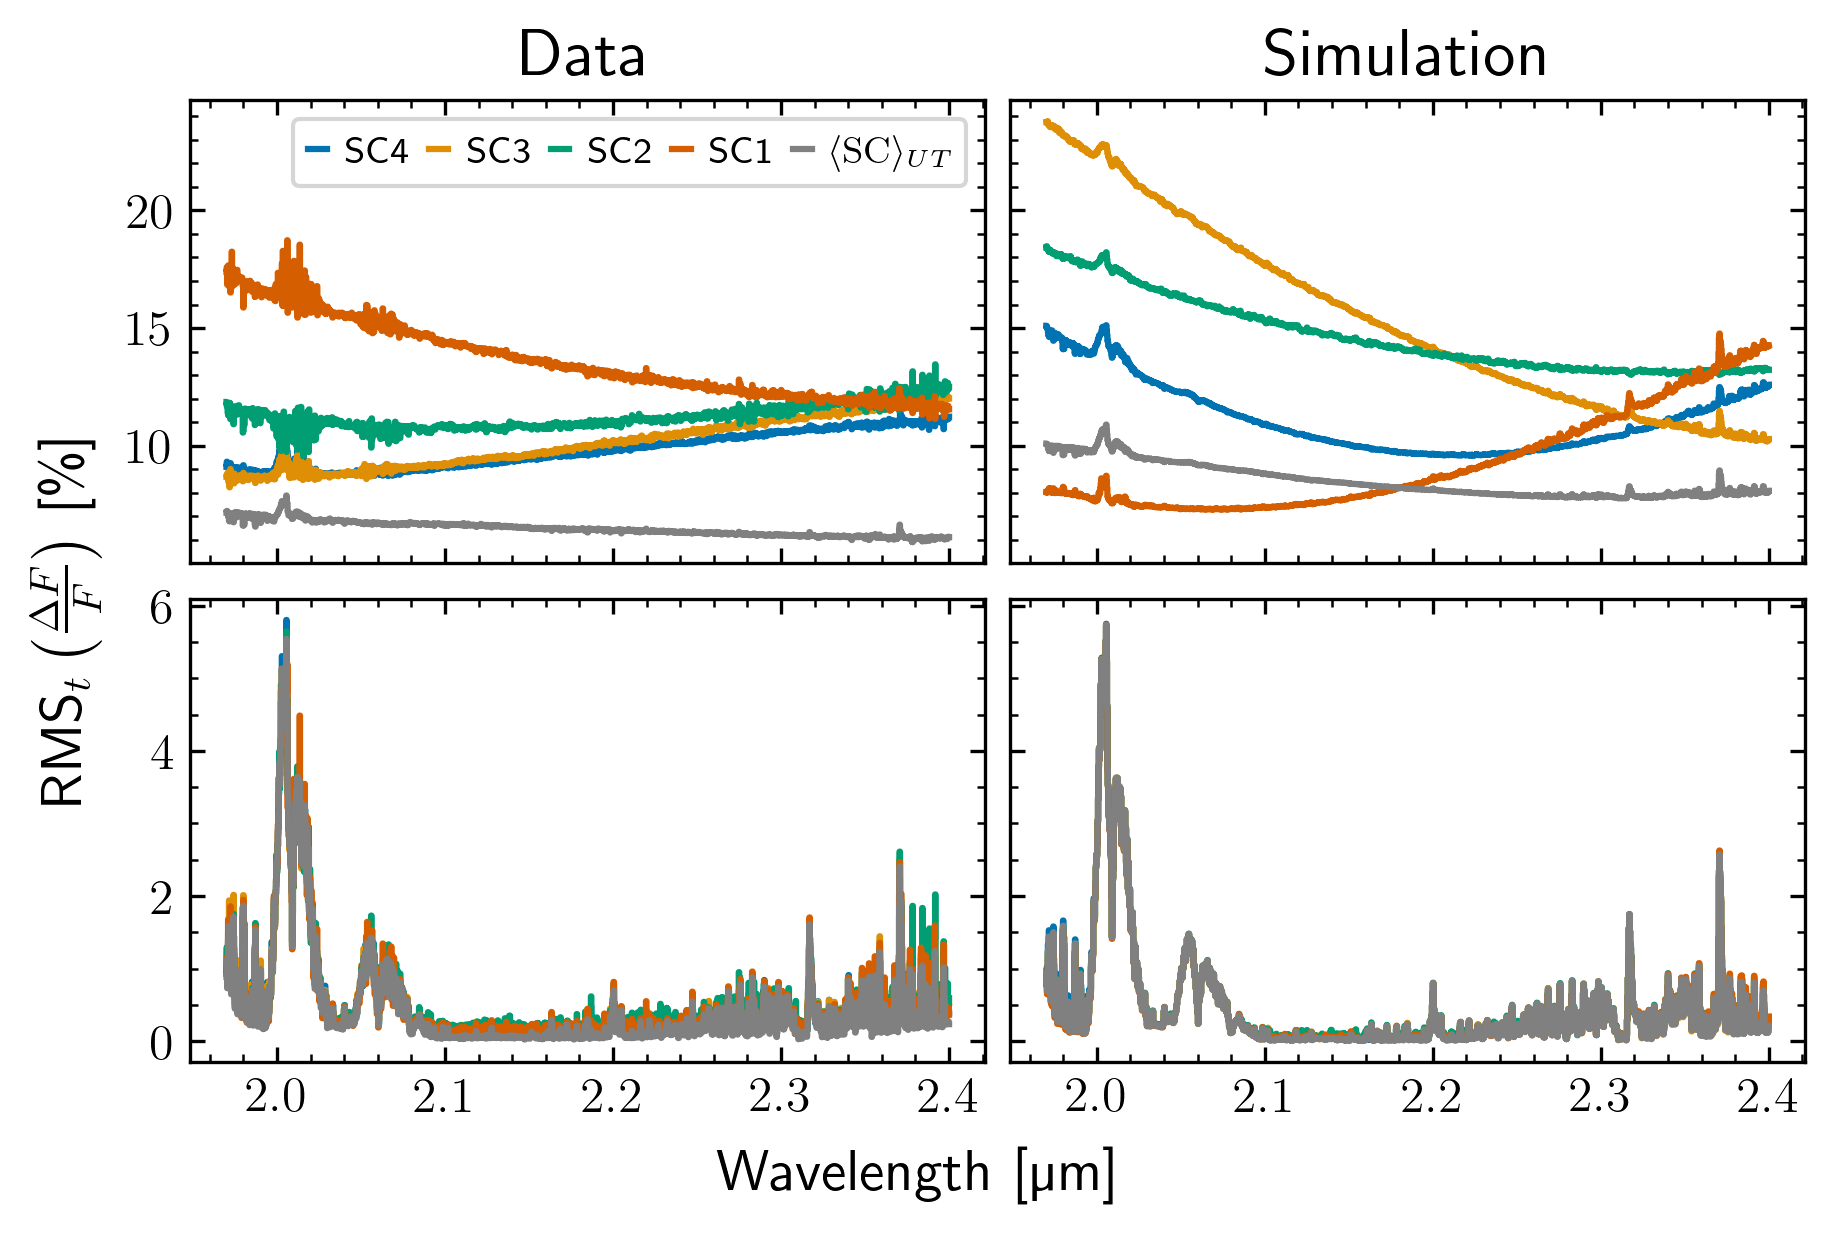

In [15]:
f_poly = np.empty((N2-N1,16,4,1628))
mf = np.mean(np.abs(flux[N1:N2]),axis=(0,1))
for i in range(N2-N1):
    for j in range(16):
        for k in range(4):
            v = np.abs(flux[i+N1,j,k])/mf[k]
            z = np.polyfit(wave[full_ref>frac_ref],v[full_ref>frac_ref],2)
            p = np.poly1d(z)(wave)
            f_poly[i,j,k] = np.abs(flux[i+N1,j,k])/p

df = (np.mean(np.abs(flux),axis=1)[1+N1:N2]-np.mean(np.abs(flux),axis=1)[N1:N2-1])/np.mean(np.abs(flux),axis=1)[N1:N2-1]
df_poly = (np.mean(np.abs(f_poly),axis=1)[1:]-np.mean(np.abs(f_poly),axis=1)[:-1])/np.mean(np.abs(f_poly),axis=1)[:-1]

df_m = (np.mean(np.abs(flux),axis=(1,2))[1+N1:N2]-np.mean(np.abs(flux),axis=(1,2))[N1:N2-1])/np.mean(np.abs(flux),axis=(1,2))[N1:N2-1]
df_poly_m = (np.mean(np.abs(f_poly),axis=(1,2))[1:]-np.mean(np.abs(f_poly),axis=(1,2))[:-1])/np.mean(np.abs(f_poly),axis=(1,2))[:-1]

f_poly_sim = np.empty((N2-N1,16,4,1628))
mf_sim = np.mean(np.abs(flux_sim),axis=(0,1))
for i in range(N2-N1):
    for j in range(16):
        for k in range(4):
            v = np.abs(flux_sim[i+N1,j,k])/mf_sim[k]
            z = np.polyfit(wave[full_ref>frac_ref],v[full_ref>frac_ref],2)
            p = np.poly1d(z)(wave)
            f_poly_sim[i,j,k] = np.abs(flux_sim[i+N1,j,k])/p

df_sim = (np.mean(np.abs(flux_sim),axis=1)[1+N1:N2]-np.mean(np.abs(flux_sim),axis=1)[N1:N2-1])/np.mean(np.abs(flux_sim),axis=1)[N1:N2-1]
df_poly_sim = (np.mean(np.abs(f_poly_sim),axis=1)[1:]-np.mean(np.abs(f_poly_sim),axis=1)[:-1])/np.mean(np.abs(f_poly_sim),axis=1)[:-1]

df_m_sim = (np.mean(np.abs(flux_sim),axis=(1,2))[1+N1:N2]-np.mean(np.abs(flux_sim),axis=(1,2))[N1:N2-1])/np.mean(np.abs(flux_sim),axis=(1,2))[N1:N2-1]
df_poly_m_sim = (np.mean(np.abs(f_poly_sim),axis=(1,2))[1:]-np.mean(np.abs(f_poly_sim),axis=(1,2))[:-1])/np.mean(np.abs(f_poly_sim),axis=(1,2))[:-1]

fig,ax = plt.subplots(2,2,dpi=300,figsize=(6,4),sharey='row',sharex=True,constrained_layout=True)
for i in range(4):
    base = col[i]
    light = adjust_color(base, 1.4)
    dark  = adjust_color(base, 0.6)

    ax[0][0].plot(wave*1e6,np.sqrt(np.mean((df[:,i])**2,axis=0))*100,color=base,ds='steps-mid',label=f'SC{4-i}')
    ax[1][0].plot(wave*1e6,np.sqrt(np.mean((df_poly[:,i])**2,axis=0))*100,color=base,ds='steps-mid')

    ax[0][1].plot(wave*1e6,np.sqrt(np.mean((df_sim[:,i])**2,axis=0))*100,color=base,ds='steps-mid')
    ax[1][1].plot(wave*1e6,np.sqrt(np.mean((df_poly_sim[:,i])**2,axis=0))*100,color=base,ds='steps-mid')

base = 'gray'
light = adjust_color(base, 1.4)
dark  = adjust_color(base, 0.6)

ax[0][0].plot(wave*1e6,np.sqrt(np.mean((df_m)**2,axis=0))*100,color=base,ds='steps-mid',label=r'$\langle \mathrm{SC} \rangle_{UT}$')
ax[1][0].plot(wave*1e6,np.sqrt(np.mean((df_poly_m)**2,axis=0))*100,color=base,ds='steps-mid',label=r'$\langle \mathrm{SC} \rangle_{UT}$')

ax[0][1].plot(wave*1e6,np.sqrt(np.mean((df_m_sim)**2,axis=0))*100,color=base,ds='steps-mid',label=r'$\langle \mathrm{SC} \rangle_{UT}$')
ax[1][1].plot(wave*1e6,np.sqrt(np.mean((df_poly_m_sim)**2,axis=0))*100,color=base,ds='steps-mid',label=r'$\langle \mathrm{SC} \rangle_{UT}$')

v = np.sqrt(np.mean((df_m)**2,axis=0))*100
z = np.polyfit(wave[full_ref>frac_ref],v[full_ref>frac_ref],2)
p = np.poly1d(z)(wave)
#ax[0][0].plot(wave*1e6,p,'--',color='black',ds='steps-mid')
#ax[1][0].plot(wave*1e6,np.sqrt(v**2-p**2),color='black',ds='steps-mid',zorder=10)

v = np.sqrt(np.mean((df_m_sim)**2,axis=0))*100
z = np.polyfit(wave[full_ref>frac_ref],v[full_ref>frac_ref],2)
p = np.poly1d(z)(wave)
#ax[0][1].plot(wave*1e6,p,'--',color='black',ds='steps-mid')
#ax[1][1].plot(wave*1e6,np.sqrt(v**2-p**2),color='black',ds='steps-mid',zorder=10)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i][j].tick_params(axis='both', which='both', top=True, right=True, direction='in',labelsize=12)
        ax[i][j].minorticks_on()
ax[0][0].legend(loc='upper right',fontsize=9,ncols=5,handlelength=0.5,handletextpad=0.5,columnspacing=0.5)
ax[0][0].set_title(f'Data',fontsize=16)
ax[0][1].set_title('Simulation',fontsize=16)        
fig.supxlabel('Wavelength [µm]',fontsize=14)
#fig.subplots_adjust(bottom=0.05,top=0.96,left=0.08,right=0.96)
fig.supylabel(r'$\text{RMS}_t\left(\frac{\Delta F}{F}\right)$ [\%]\,',fontsize=14)
#fig.subplots_adjust(bottom=0.08,top=0.94,left=0.12,right=0.98)
#fig.tight_layout()
#ax[1][0].set_yscale('log')
#plt.savefig('/home/sauter/PhD/SIMTERFERE/Plots/RMS_flux_diff_sim.pdf',bbox_inches='tight')
plt.show()

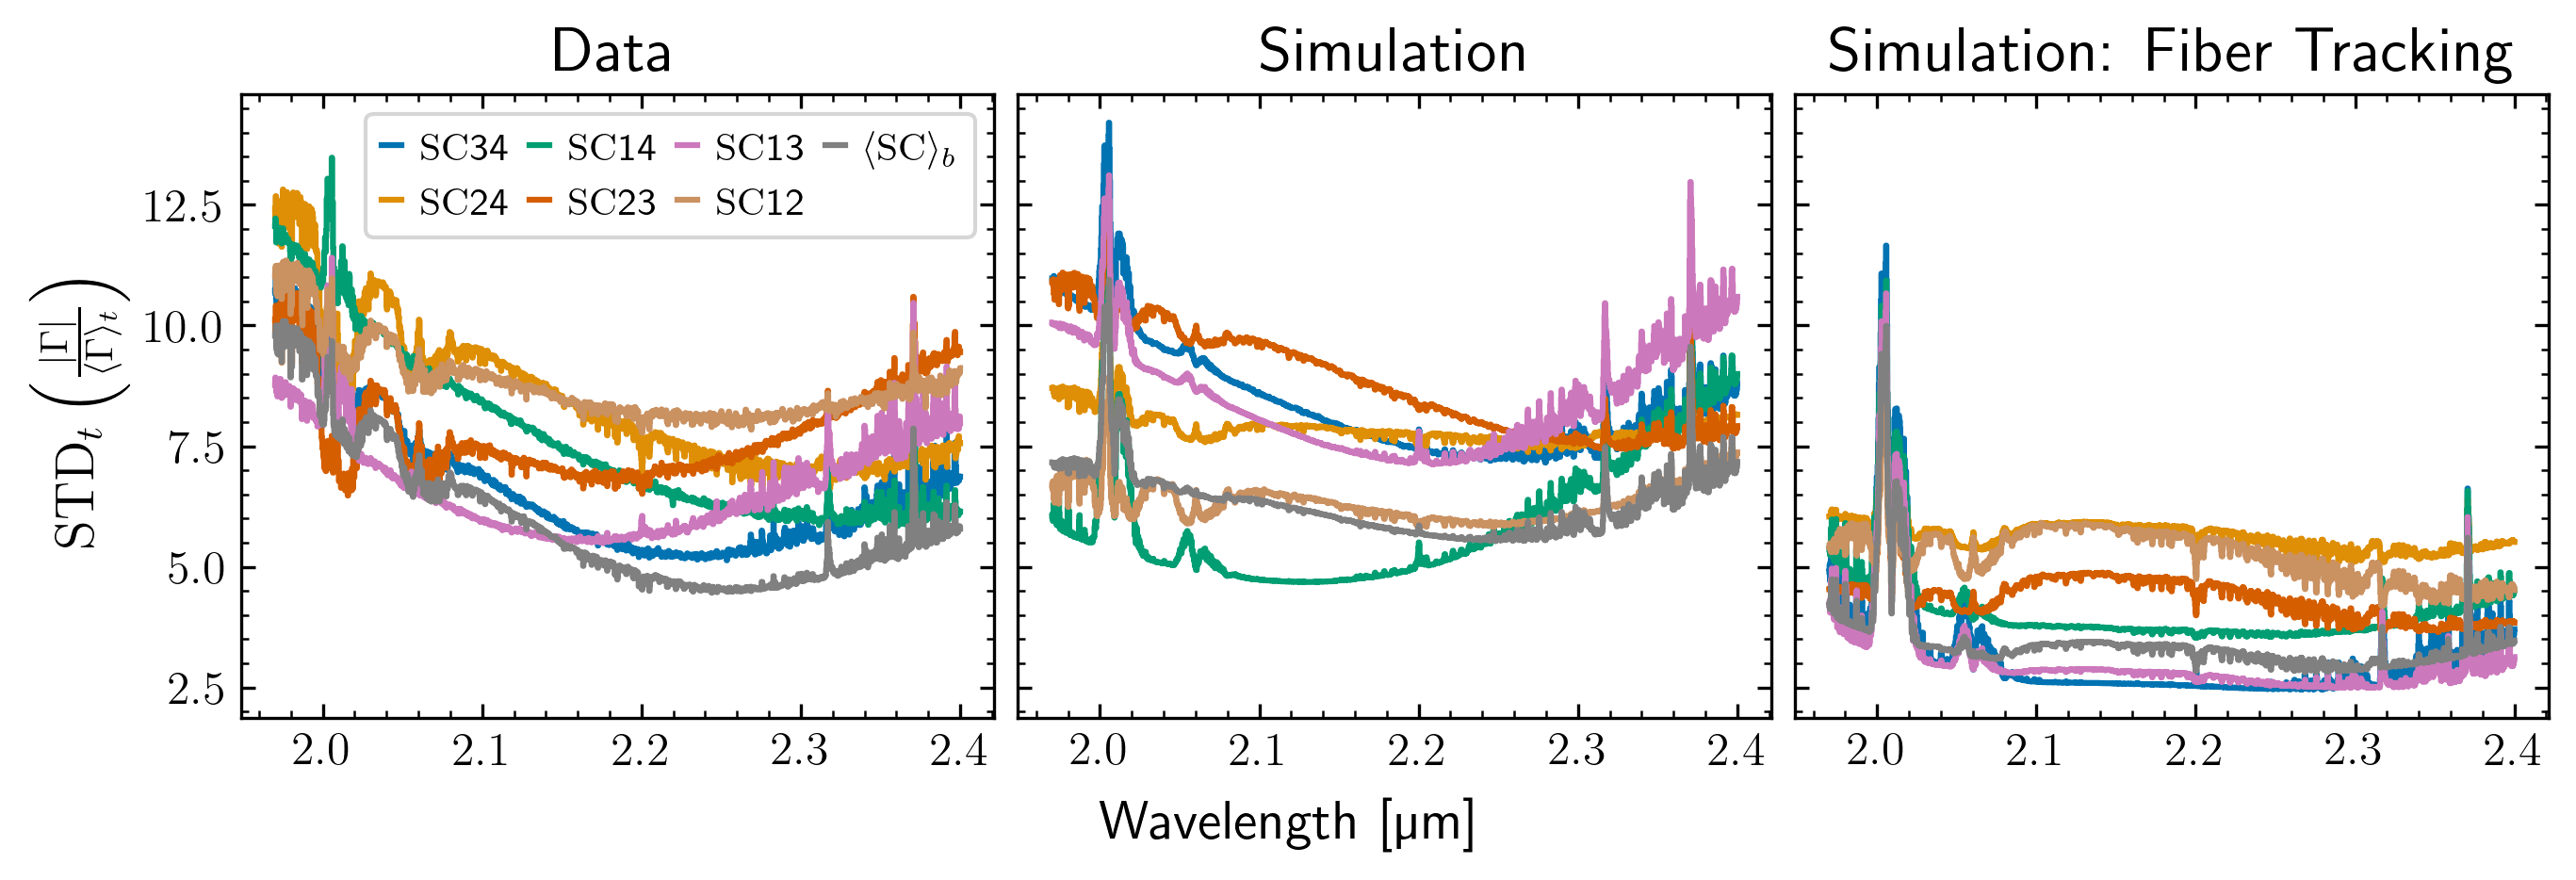

In [16]:
fig,ax = plt.subplots(1,3,dpi=300,sharex=True,sharey=True,figsize=(9,3),constrained_layout=True)

for i in range(6):
    ax[0].plot(wave*1e6,100*np.std(np.mean(np.abs(vis[:,:,i]),axis=1)/np.mean(np.abs(vis[:,:,i]),axis=(0,1)),axis=0),color=col[i],ds='steps-mid',label=r'$\mathrm{SC}$'+baseline_labels[i])
    ax[1].plot(wave*1e6,100*np.std(np.mean(np.abs(vis_sim[:,:,i]),axis=1)/np.mean(np.abs(vis_sim[:,:,i]),axis=(0,1)),axis=0),color=col[i],ds='steps-mid')
    ax[2].plot(wave*1e6,100*np.std(np.mean(np.abs(vis_sim_align[:,:,i]),axis=1)/np.mean(np.abs(vis_sim_align[:,:,i]),axis=(0,1)),axis=0),color=col[i],ds='steps-mid')

ax[0].plot(wave*1e6,100*np.std(np.mean(np.abs(vis),axis=(1,2))/np.mean(np.abs(vis),axis=(0,1,2)),axis=0),color='gray',ds='steps-mid',label=r'$\langle\mathrm{SC}\rangle_b$')
ax[1].plot(wave*1e6,100*np.std(np.mean(np.abs(vis_sim),axis=(1,2))/np.mean(np.abs(vis_sim),axis=(0,1,2)),axis=0),color='gray',ds='steps-mid')
ax[2].plot(wave*1e6,100*np.std(np.mean(np.abs(vis_sim_align),axis=(1,2))/np.mean(np.abs(vis_sim_align),axis=(0,1,2)),axis=0),color='gray',ds='steps-mid')

for i in range(ax.shape[0]):
    ax[i].tick_params(axis='both', which='both', top=True, right=True, direction='in',labelsize=12)
    ax[i].minorticks_on()
ax[0].legend(loc='upper right',fontsize=10,ncols=4,handlelength=0.5,handletextpad=0.5,columnspacing=0.5)

fig.supxlabel('Wavelength [µm]',fontsize=14)
ax[0].set_ylabel(r'$\mathrm{STD}_{t} \left (\frac{|\Gamma|}{\langle \Gamma \rangle_{t}}\right)$',fontsize=14)
ax[0].set_title('Data',fontsize=16)
ax[1].set_title('Simulation',fontsize=16)   
ax[2].set_title('Simulation: Fiber Tracking',fontsize=16)     
plt.savefig('/home/sauter/PhD/SIMTERFERE/Plots/Normalized_STD_full.pdf',bbox_inches='tight')
plt.show()

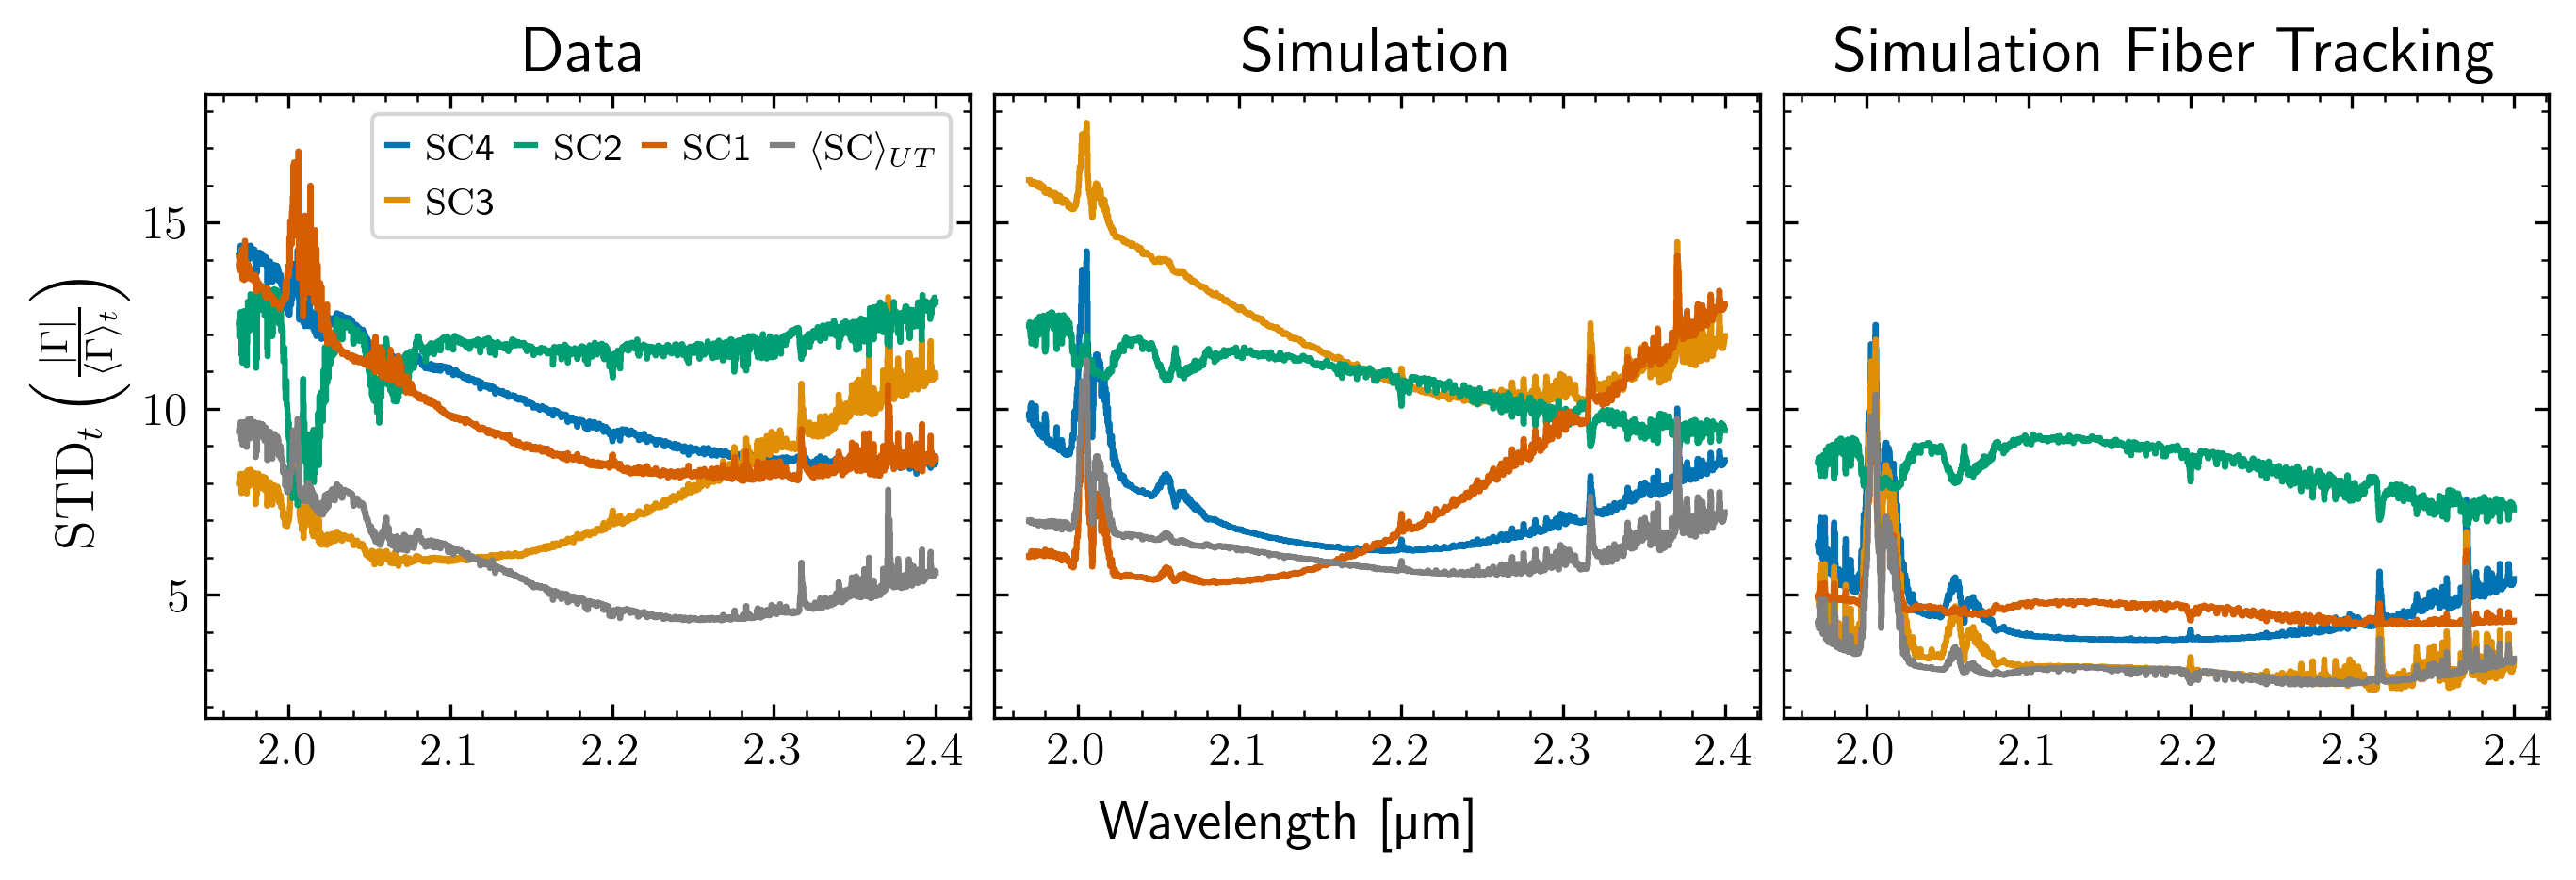

In [17]:
fig,ax = plt.subplots(1,3,dpi=300,sharex=True,sharey=True,figsize=(9,3),constrained_layout=True)

for i in range(4):
    ax[0].plot(wave*1e6,100*np.std(np.mean(np.abs(flux[:,:,i]),axis=1)/np.mean(np.abs(flux[:,:,i]),axis=(0,1)),axis=0),color=col[i],ds='steps-mid',label=r'$\mathrm{SC}$'+f'{4-i}')
    ax[1].plot(wave*1e6,100*np.std(np.mean(np.abs(flux_sim[:,:,i]),axis=1)/np.mean(np.abs(flux_sim[:,:,i]),axis=(0,1)),axis=0),color=col[i],ds='steps-mid')
    ax[2].plot(wave*1e6,100*np.std(np.mean(np.abs(flux_sim_align[:,:,i]),axis=1)/np.mean(np.abs(flux_sim_align[:,:,i]),axis=(0,1)),axis=0),color=col[i],ds='steps-mid')

ax[0].plot(wave*1e6,100*np.std(np.mean(np.abs(flux),axis=(1,2))/np.mean(np.abs(flux),axis=(0,1,2)),axis=0),color='gray',ds='steps-mid',label=r'$\langle\mathrm{SC}\rangle_{UT}$')
ax[1].plot(wave*1e6,100*np.std(np.mean(np.abs(flux_sim),axis=(1,2))/np.mean(np.abs(flux_sim),axis=(0,1,2)),axis=0),color='gray',ds='steps-mid')
ax[2].plot(wave*1e6,100*np.std(np.mean(np.abs(flux_sim_align),axis=(1,2))/np.mean(np.abs(flux_sim_align),axis=(0,1,2)),axis=0),color='gray',ds='steps-mid')

for i in range(ax.shape[0]):
    ax[i].tick_params(axis='both', which='both', top=True, right=True, direction='in',labelsize=12)
    ax[i].minorticks_on()
ax[0].legend(loc='upper right',fontsize=10,ncols=4,handlelength=0.5,handletextpad=0.5,columnspacing=0.5)

fig.supxlabel('Wavelength [µm]',fontsize=14)
ax[0].set_ylabel(r'$\mathrm{STD}_{t} \left (\frac{|\Gamma|}{\langle \Gamma \rangle_{t}}\right)$',fontsize=14)
ax[0].set_title('Data',fontsize=16)
ax[1].set_title('Simulation',fontsize=16)   
ax[2].set_title('Simulation Fiber Tracking',fontsize=16)     
#plt.savefig('/home/sauter/PhD/SIMTERFERE/Plots/Normalized_STD_full.pdf',bbox_inches='tight')
plt.show()

In [18]:
labels = ['UT4','UT3','UT2','UT1']
bl_labels = ['SC43','SC42','SC41','SC32','SC31','SC21']
bl_labels_ft = ['FT43','FT42','FT41','FT32','FT31','FT21']
col = sns.color_palette('colorblind')
k = 0

for i in range(16):
    fig,ax = plt.subplots(2,2,dpi=300,figsize=(6,4),sharex=True,sharey='row', constrained_layout=True)
    for j in range(6):
        base = col[j]
        light = adjust_color(base, 1.4)
        ax[0][0].plot(wave*1e6,np.abs(vis[k,i,j,:])/np.max(np.abs(vis)),color=base,ds='steps-mid',label=bl_labels[j])
        ax[0][1].plot(wave*1e6,np.abs(vis_sim[k,i,j,:])/np.max(np.abs(vis_sim[k])),color=base,ds='steps-mid')
        v = (np.abs(vis[k,i,j,:])-np.mean(np.abs(vis[k,:,j,:]),axis=0))/np.mean(np.abs(vis[k,:,j,:]),axis=0)
        z = np.polyfit(wave,v,2)
        p = np.poly1d(z)(wave)
        ax[1][0].plot(wave*1e6,100*v,color=base,ds='steps-mid')
        ax[1][0].plot(wave*1e6,100*p,'--',color='white')
        v = (np.abs(vis_sim[k,i,j,:])-np.mean(np.abs(vis_sim[k,:,j,:]),axis=0))/np.mean(np.abs(vis_sim[k,:,j,:]),axis=0)
        v_ft = (np.abs(vis_ft_sim[k,i,j,:])-np.mean(np.abs(vis_ft_sim[k,:,j,:]),axis=0))/np.mean(np.abs(vis_ft_sim[k,:,j,:]),axis=0)
        z = np.polyfit(wave,v,2)
        p = np.poly1d(z)(wave)
        z_ft = np.polyfit(wave_ft,v_ft,2)
        p_ft = np.poly1d(z_ft)(wave_ft)
        ax[1][1].plot(wave*1e6,100*v,color=base,ds='steps-mid',lw=3)
        #ax[1].plot(wave_ft*1e6,v_ft,color=light,ds='steps-mid')
        ax[1][1].plot(wave*1e6,100*p,'--',color='white')
    for j in range(2):
        for l in range(2):
            ax[j][l].tick_params(axis='both', which='both', top=True, right=True, direction='in',labelsize=12)
            ax[j][l].minorticks_on()
    base = 'gray'
    light = adjust_color(base, 1.4)
    ax[0][0].plot(wave*1e6,np.mean(np.abs(vis[k,i])/np.max(np.abs(vis)),axis=0),color=base,ds='steps-mid',label=r'$\langle \mathrm{SC} \rangle_b$')
    v = (np.mean(np.abs(vis[k,i]),axis=0)-np.mean(np.abs(vis[k]),axis=(0,1)))/np.mean(np.abs(vis[k]),axis=(0,1))
    z = np.polyfit(wave,v,2)
    p = np.poly1d(z)(wave)
    ax[1][0].plot(wave*1e6,100*v,color=base,ds='steps-mid')
    ax[1][0].plot(wave*1e6,100*p,'--',color='white')

    ax[0][1].plot(wave*1e6,np.mean(np.abs(vis_sim[k,i])/np.max(np.abs(vis_sim[k])),axis=0),color=base,ds='steps-mid')
    v = (np.mean(np.abs(vis_sim[k,i]),axis=0)-np.mean(np.abs(vis_sim[k]),axis=(0,1)))/np.mean(np.abs(vis_sim[k]),axis=(0,1))
    z = np.polyfit(wave,v,2)
    p = np.poly1d(z)(wave)
    ax[1][1].plot(wave*1e6,100*v,color=base,ds='steps-mid',lw=3)
    ax[1][1].plot(wave*1e6,100*p,'--',color='white')
    ax[0][0].legend(loc='upper right',fontsize=10,ncols=2,handlelength=0.5,handletextpad=0.5,columnspacing=0.5)
    ax[0][0].set_ylabel(r"$|\Gamma|$ (normalized)",fontsize=14)
    ax[1][0].set_ylabel(r"$\frac{|\Gamma|-\langle |\Gamma| \rangle_t}{\langle |\Gamma| \rangle_t}$ [\%]",fontsize=14)
    fig.supxlabel('Wavelength [µm]',fontsize=14)
    ax[0][0].set_title(f'Exp{k+1}, Int{i+1}: AM = {AM[k]:.2f}',fontsize=16)
    ax[0][1].set_title('Simulation',fontsize=16)
    ax[0][0].set_ylim([0,1])
    ax[1][0].set_ylim([-25,25])
    #plt.tight_layout()
    plt.savefig(f"/home/sauter/PhD/SIMTERFERE/Plots/flux_vis_sim_variability_{k}_exp/frame{i}.png")
    plt.savefig(f"/home/sauter/PhD/SIMTERFERE/Plots/flux_vis_sim_variability_{k}_exp/frame{i}.pdf",bbox_inches='tight')
    plt.close()

In [19]:
std = np.empty((18,39,4))

#"""
n = 37
s = 15
npix = round(n/(1.654*1e-6/8.1*180/np.pi*3.6e6/17.8))
MJD = np.array([])
curv = np.empty((18,4))
opl = np.empty((18,4))
for i in range(18):
    print(files_std[i])
    dat = fits.open('/home/sauter/PhD/beta Pic/betaPic/betaPic/GRAVI.'+files_std[i]+'.fits')[4].data

    header = fits.open('/home/sauter/PhD/beta Pic/betaPic/betaPic/GRAVI.'+files_std[i]+'.fits')[0].header
    MJD = np.append(MJD,header['MJD-OBS'])
    parang_start = header['HIERARCH ESO ISS PARANG START']
    parang_end = header["HIERARCH ESO ISS PARANG END"]

    reference_pos = [(128,87),(368,88),(620,96),(877,91)]

    curv[i,0] = header['HIERARCH ESO DEL DLT4 VCM CURV']
    curv[i,1] = header['HIERARCH ESO DEL DLT3 VCM CURV']
    curv[i,2] = header['HIERARCH ESO DEL DLT2 VCM CURV']
    curv[i,3] = header['HIERARCH ESO DEL DLT1 VCM CURV']

    opl[i,0] = (header['HIERARCH ESO DEL DLT4 OPL START']+header['HIERARCH ESO DEL DLT4 OPL END'])/2
    opl[i,1] = (header['HIERARCH ESO DEL DLT3 OPL START']+header['HIERARCH ESO DEL DLT2 OPL END'])/2
    opl[i,2] = (header['HIERARCH ESO DEL DLT2 OPL START']+header['HIERARCH ESO DEL DLT2 OPL END'])/2
    opl[i,3] = (header['HIERARCH ESO DEL DLT1 OPL START']+header['HIERARCH ESO DEL DLT1 OPL END'])/2


    for j in range(39):
        rot = -60.3 + (-4.161 - parang_start) + (parang_start - parang_end) * j / 15
        phase = np.loadtxt(root_std+files_std[i]+f'/frame{j}.txt')
        for k in range(4):
            tml = Wavefront.get_aperture(n,npix,1.654,4-k,rot)
            rp = reference_pos[k]
            psf = np.abs(np.fft.fftshift(np.fft.fft2(tml*np.exp(1j*phase[k].reshape(tml.shape)))))**2
            tp = (phase[k].reshape(tml.shape)*tml)[n-npix:n+npix+1,n-npix:n+npix+1]
            tml_sub = tml[n-npix:n+npix+1,n-npix:n+npix+1]
            tp[tml_sub==0] = np.nan
            ny, nx = tp.shape
            y, x = np.indices((ny, nx))
            valid = ~np.isnan(tp)
            # Flatten the valid coordinates and phase values
            xv = x[valid].ravel()
            yv = y[valid].ravel()
            phiv = tp[valid].ravel()

            # Design matrix: [1, x, y]
            A = np.vstack([np.ones_like(xv), xv, yv]).T

            # Solve least squares: A @ [a, b, c] = phiv
            coeffs, residuals, rank, s = np.linalg.lstsq(A, phiv, rcond=None)
            a, b, c = coeffs

            # You can now reconstruct the fitted plane over the full domain:
            tp_fit = a + b * x + c * y
            tp_res = (tp-tp_fit+np.pi)%(2*np.pi)-np.pi
            #std[i,j,k] = np.std(tp_res[tml_sub!=0])
            std[i,j,k] = circstd(tp_res[tml_sub!=0],high=np.pi,low=-np.pi)

2024-12-20T00:51:57.856
2024-12-20T01:31:54.958
2024-12-20T02:10:16.056
2024-12-20T02:12:16.060
2024-12-20T02:37:52.126
2024-12-20T02:54:43.169
2024-12-20T03:20:13.233
2024-12-20T03:36:55.276
2024-12-20T04:02:37.342
2024-12-20T04:21:04.388
2024-12-20T04:46:25.452
2024-12-20T05:02:52.495
2024-12-20T05:30:10.564
2024-12-20T05:46:49.607
2024-12-20T06:12:13.671
2024-12-20T06:28:46.713
2024-12-20T06:54:13.778
2024-12-20T07:10:55.820


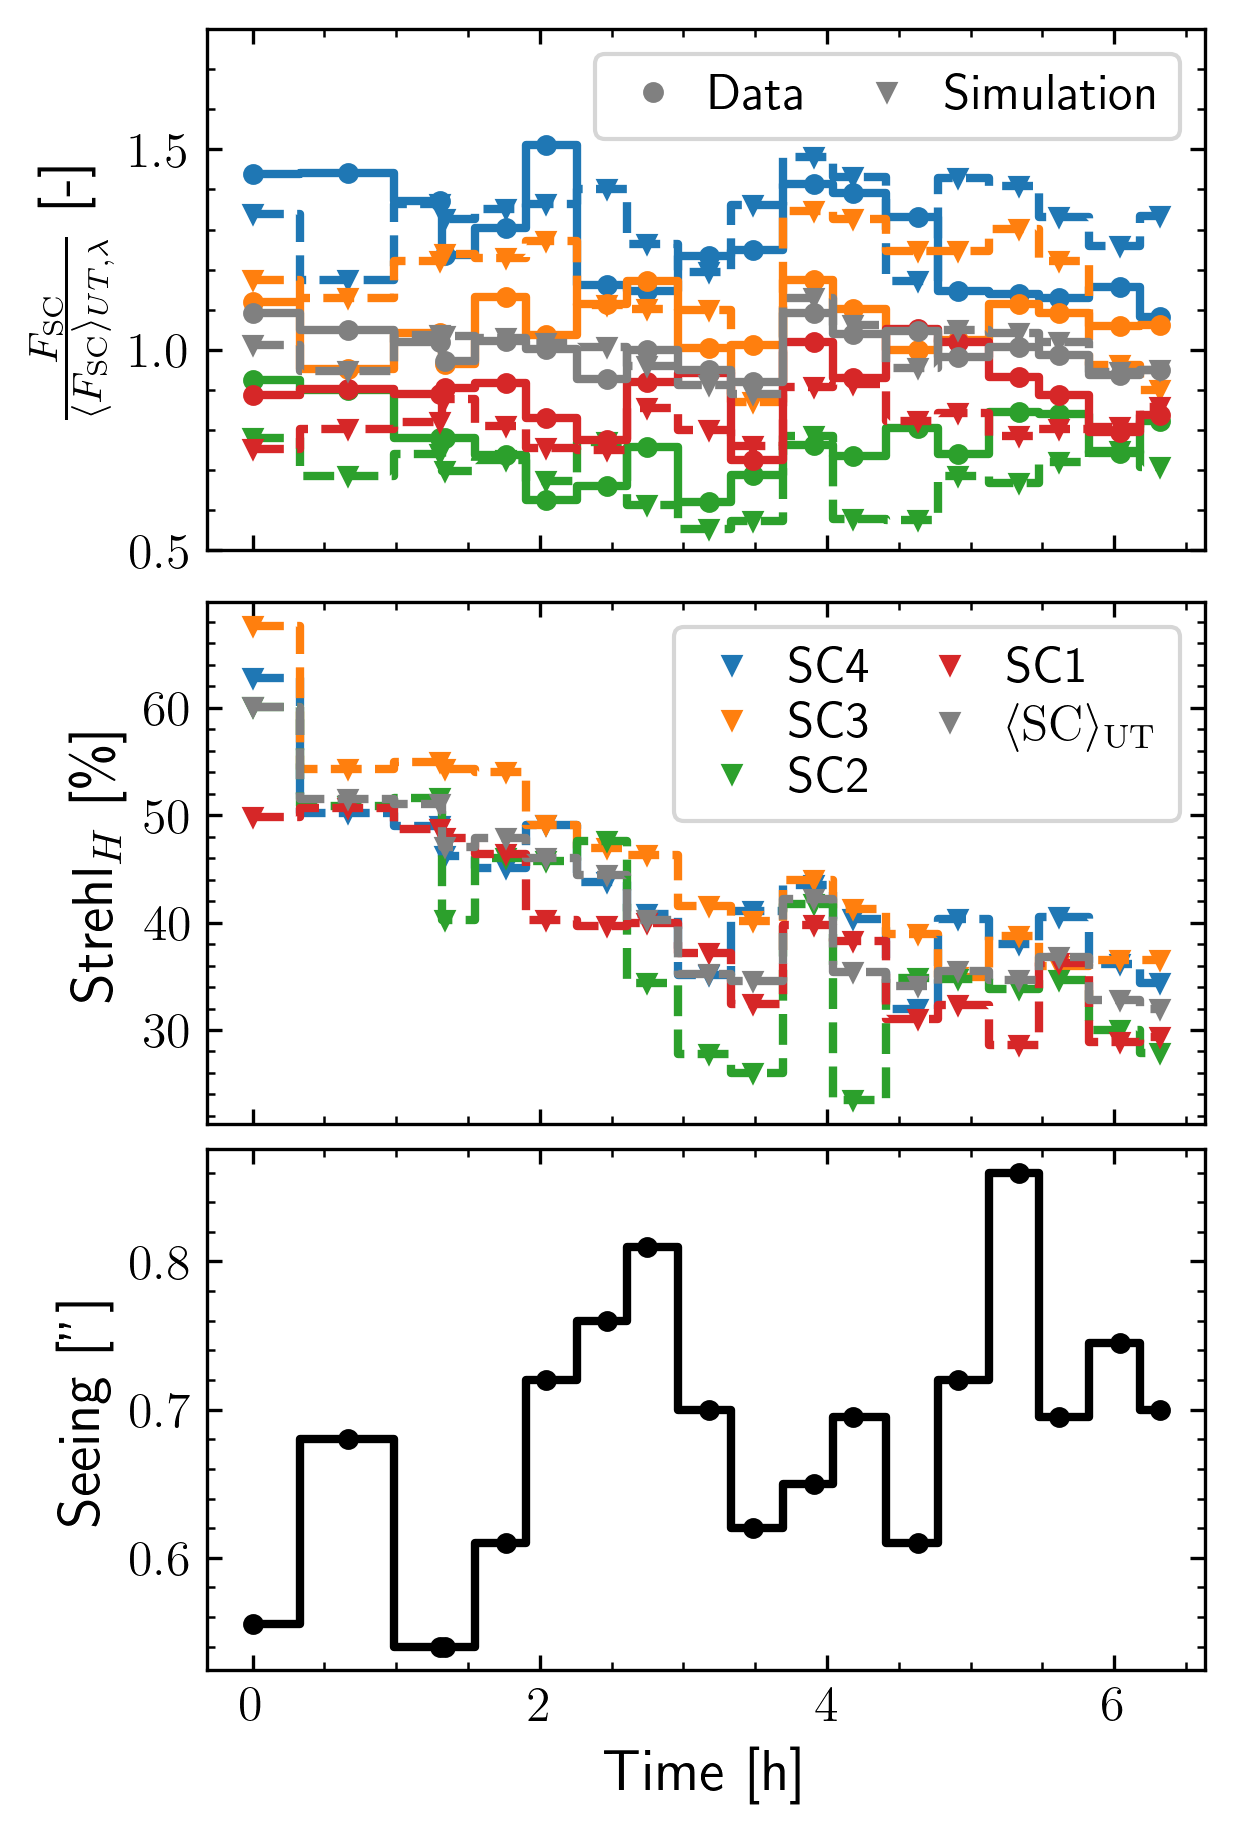

In [20]:
col = sns.color_palette('colorblind')

fig,ax = plt.subplots(3,1,dpi=300,figsize=(4,6),sharex=True,constrained_layout=True)
for i in range(4):
    ax[1].plot((MJD-MJD[0])*24,100*np.exp(-np.mean(std[:,:,i],axis=1)**2),'--',ds="steps-mid",color=f'C{i}',lw=2)
    ax[1].plot((MJD-MJD[0])*24,100*np.exp(-np.mean(std[:,:,i],axis=1)**2),'v',label=f'SC{4-i}',color=f'C{i}',ms=4)
    ax[0].plot((MJD-MJD[0])*24,(np.mean(flux[:,:,i],axis=(1,2))/np.mean(flux[:,:,])),ds='steps-mid',color=f'C{i}',lw=2)
    ax[0].plot((MJD-MJD[0])*24,(np.mean(flux[:,:,i],axis=(1,2))/np.mean(flux[:,:,])),'o',color=f'C{i}',ms=4)
    ax[0].plot((MJD-MJD[0])*24,(np.mean(flux_sim[:,:,i],axis=(1,2))/np.mean(flux_sim[:,:,])),'--',ds='steps-mid',color=f'C{i}',lw=2)
    ax[0].plot((MJD-MJD[0])*24,(np.mean(flux_sim[:,:,i],axis=(1,2))/np.mean(flux_sim[:,:,])),'v',ds='steps-mid',color=f'C{i}',ms=4)
ax[0].plot((MJD-MJD[0])*24,(np.mean(flux,axis=(1,2,3))/np.mean(flux)),ds='steps-mid',color='gray',lw=2)
ax[0].plot((MJD-MJD[0])*24,(np.mean(flux,axis=(1,2,3))/np.mean(flux)),'o',color='gray',ms=4,label='Data')
ax[0].plot((MJD-MJD[0])*24,(np.mean(flux_sim,axis=(1,2,3))/np.mean(flux_sim)),'--',ds='steps-mid',color='gray',lw=2)
ax[0].plot((MJD-MJD[0])*24,(np.mean(flux_sim,axis=(1,2,3))/np.mean(flux_sim)),'v',color='gray',ms=4,label='Simulation')
ax[1].plot((MJD-MJD[0])*24,100*np.exp(-np.mean(std,axis=(1,2))**2),'--',ds="steps-mid",color='gray',lw=2)
ax[1].plot((MJD-MJD[0])*24,100*np.exp(-np.mean(std,axis=(1,2))**2),'v',ds="steps-mid",label=r'$\langle \mathrm{SC} \rangle_{\mathrm{UT}}$',color='gray',ms=4)
#ax[2].plot((MJD-MJD[0])*24,0.98*500e-9/(np.array(Seeing)/3600*np.pi/180),ds='steps-mid',color='black')
ax[2].plot((MJD-MJD[0])*24,Seeing,ds='steps-mid',color='black',lw=2)
ax[2].plot((MJD-MJD[0])*24,Seeing,'o',color='black',ms=4)
#ax[2].plot((MJD-MJD[0])*24,Temp,ds='steps-mid',color='black')
ax[1].set_ylabel(r'Strehl$_{H}$ [\%]',fontsize=14)
ax[0].set_ylabel(r'$\frac{F_{\mathrm{SC}}}{\langle F_{\mathrm{SC}} \rangle_{UT,\lambda}}$ [-]',fontsize=14)
#ax[2].set_ylabel('Fried Parameter [m]',fontsize=14)
ax[2].set_ylabel('Seeing ["]',fontsize=14)
for i in range(ax.shape[0]):
    ax[i].tick_params(axis='both', which='both', top=True, right=True, direction='in',labelsize=12)
    ax[i].minorticks_on()
ax[0].legend(loc='upper right',ncols=2, handlelength=1.5, handletextpad=0.4, columnspacing=0.8, labelspacing=0.2,fontsize=12)
ax[1].legend(loc='upper right',ncols=2, handlelength=1.5, handletextpad=0.4, columnspacing=0.8, labelspacing=0.2,fontsize=12)
ax[2].set_xlabel('Time [h]',fontsize=14)
ax[0].set_ylim([0.5,1.8])
#ax[1].set_ylim([0.5,1.8])
#plt.tight_layout()
plt.savefig("/home/sauter/PhD/SIMTERFERE/Plots/wavefront_flux.pdf",bbox_inches='tight')
plt.show()


In [21]:
tm_full = np.empty((N2,1628))
tm_co2 = np.empty((N2,1628))
tm_h2o = np.empty((N2,1628))
tm_ch4 = np.empty((N2,1628))
tm_co = np.empty((N2,1628))

wavestart = 1.9e3
waveend = 2.5e3
dw = -0.00059
for i in range(N2):
    # Make the model
    print(f'Full {i}')
    modeler = Modeler()
    full = modeler.MakeModel(
        pressure=Pressure[i],
        temperature=Temp[i]+273.15,
        lowfreq=1e7/waveend,
        highfreq=1e7/wavestart,
        angle=180/np.pi*np.arccos(1/AM[i]),
        humidity=Humid[i]*1.3,
        lat=-(24+37/60+39/3600),
        alt=2.635,
        co2=368.5*1.25,
        ch4=1.8*1.4,
        ).toarray()
    
    tm_full[i] = interp1d(
        1e-3*full[:,0]-dw,
        gaussian_filter(full[:,1],len(full[:,0][(1e-3*full[:,0]-dw>1.97)&(1e-3*full[:,0]-dw<2.4)])/1628),
        kind="linear",
        fill_value="extrapolate")(1e6*wave)

    # Make the model
    print(f'CO2 {i}')
    modeler = Modeler()
    co2 = modeler.MakeModel(
        pressure=Pressure[i],
        temperature=Temp[i]+273.15,
        lowfreq=1e7/waveend,
        highfreq=1e7/wavestart,
        angle=180/np.pi*np.arccos(1/AM[i]),
        humidity=0.,
        co2=368.5*1.25,
        o3=0.,
        n2o=0.,
        co=0.,
        ch4=0.,
        o2=0.,
        no=0.,
        so2=0.,
        no2=0.,
        nh3=0.,
        hno3=0.,
        lat=-(24+37/60+39/3600),
        alt=2.635,
        ).toarray()
    
    tm_co2[i] = interp1d(
        1e-3*co2[:,0]-dw,
        gaussian_filter(co2[:,1],len(co2[:,0][(1e-3*co2[:,0]-dw>1.97)&(1e-3*co2[:,0]-dw<2.4)])/1628),
        kind="linear",
        fill_value="extrapolate")(1e6*wave)

    print(f'H2O {i}')
    modeler = Modeler()
    h2o = modeler.MakeModel(
        pressure=Pressure[i],
        temperature=Temp[i]+273.15,
        lowfreq=1e7/waveend,
        highfreq=1e7/wavestart,
        angle=180/np.pi*np.arccos(1/AM[i]),
        humidity=Humid[i]*1.3,
        co2=0.,
        o3=0.,
        n2o=0.,
        co=0.,
        ch4=0.,
        o2=0.,
        no=0.,
        so2=0.,
        no2=0.,
        nh3=0.,
        hno3=0.,
        lat=-(24+37/60+39/3600),
        alt=2.635,
        ).toarray()
    
    tm_h2o[i] = interp1d(
        1e-3*h2o[:,0]-dw,
        gaussian_filter(h2o[:,1],len(h2o[:,0][(1e-3*h2o[:,0]-dw>1.97)&(1e-3*h2o[:,0]-dw<2.4)])/1628),
        kind="linear",
        fill_value="extrapolate")(1e6*wave)

    print(f'CH4 {i}')
    modeler = Modeler()
    ch4 = modeler.MakeModel(
        pressure=Pressure[i],
        temperature=Temp[i]+273.15,
        lowfreq=1e7/waveend,
        highfreq=1e7/wavestart,
        angle=180/np.pi*np.arccos(1/AM[i]),
        humidity=0.,
        co2=0.,
        o3=0.,
        n2o=0.,
        co=0.,
        ch4=1.8*1.4,
        o2=0.,
        no=0.,
        so2=0.,
        no2=0.,
        nh3=0.,
        hno3=0.,
        lat=-(24+37/60+39/3600),
        alt=2.635,
        ).toarray()
    
    tm_ch4[i] = interp1d(
        1e-3*ch4[:,0]-dw,
        gaussian_filter(ch4[:,1],len(ch4[:,0][(1e-3*ch4[:,0]-dw>1.97)&(1e-3*ch4[:,0]-dw<2.4)])/1628),
        kind="linear",
        fill_value="extrapolate")(1e6*wave)

    print(f'CO {i}')
    modeler = Modeler()
    co = modeler.MakeModel(
        pressure=Pressure[i],
        temperature=Temp[i]+273.15,
        lowfreq=1e7/waveend,
        highfreq=1e7/wavestart,
        angle=180/np.pi*np.arccos(1/AM[i]),
        humidity=0.,
        co2=0.,
        o3=0.,
        n2o=0.,
        co=0.14,
        ch4=0.,
        o2=0.,
        no=0.,
        so2=0.,
        no2=0.,
        nh3=0.,
        hno3=0.,
        lat=-(24+37/60+39/3600),
        alt=2.635,
        ).toarray()
    
    tm_co[i] = interp1d(
        1e-3*co[:,0]-dw,
        gaussian_filter(co[:,1],len(co[:,0][(1e-3*co[:,0]-dw>1.97)&(1e-3*co[:,0]-dw<2.4)])/1628),
        kind="linear",
        fill_value="extrapolate")(1e6*wave)

Full 0

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
27.33user 1.81system 0:29.17elapsed 99%CPU (0avgtext+0avgdata 7856maxresident)k
40inputs+1868008outputs (1major+1097minor)pagefaults 0swaps


CO2 0

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
24.90user 1.71system 0:26.62elapsed 99%CPU (0avgtext+0avgdata 7956maxresident)k
0inputs+1696664outputs (0major+1099minor)pagefaults 0swaps


H2O 0

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.54user 1.72system 0:05.27elapsed 99%CPU (0avgtext+0avgdata 7724maxresident)k
0inputs+1573568outputs (0major+1096minor)pagefaults 0swaps


CH4 0

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.35user 1.66system 0:06.02elapsed 100%CPU (0avgtext+0avgdata 8004maxresident)k
0inputs+1601640outputs (0major+1105minor)pagefaults 0swaps


CO 0

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.53user 1.57system 0:05.11elapsed 99%CPU (0avgtext+0avgdata 7936maxresident)k
1024inputs+1509728outputs (0major+1086minor)pagefaults 0swaps


Full 1

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
29.98user 1.98system 0:32.00elapsed 99%CPU (0avgtext+0avgdata 8000maxresident)k
5632inputs+1868048outputs (0major+1100minor)pagefaults 0swaps


CO2 1

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
40.19user 3.74system 0:44.23elapsed 99%CPU (0avgtext+0avgdata 7596maxresident)k
1704inputs+1696832outputs (13major+1082minor)pagefaults 0swaps


H2O 1

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
5.90user 3.61system 0:09.63elapsed 98%CPU (0avgtext+0avgdata 7744maxresident)k
0inputs+1573584outputs (0major+1095minor)pagefaults 0swaps


CH4 1

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
7.39user 3.93system 0:11.46elapsed 98%CPU (0avgtext+0avgdata 7688maxresident)k
0inputs+1601688outputs (0major+1095minor)pagefaults 0swaps


CO 1

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
5.76user 3.19system 0:08.99elapsed 99%CPU (0avgtext+0avgdata 7972maxresident)k
24inputs+1509728outputs (0major+1087minor)pagefaults 0swaps


Full 2

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
44.30user 4.04system 0:48.61elapsed 99%CPU (0avgtext+0avgdata 7880maxresident)k
0inputs+1868184outputs (0major+1099minor)pagefaults 0swaps


CO2 2

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
34.47user 3.08system 0:37.63elapsed 99%CPU (0avgtext+0avgdata 8000maxresident)k
0inputs+1696944outputs (0major+1104minor)pagefaults 0swaps


H2O 2

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.29user 2.25system 0:06.55elapsed 99%CPU (0avgtext+0avgdata 7964maxresident)k
0inputs+1573584outputs (0major+1100minor)pagefaults 0swaps


CH4 2

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.73user 1.69system 0:06.42elapsed 99%CPU (0avgtext+0avgdata 7860maxresident)k
0inputs+1601656outputs (0major+1097minor)pagefaults 0swaps


CO 2

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.70user 1.65system 0:05.35elapsed 99%CPU (0avgtext+0avgdata 7940maxresident)k
0inputs+1509720outputs (0major+1089minor)pagefaults 0swaps


Full 3

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
30.03user 1.96system 0:32.03elapsed 99%CPU (0avgtext+0avgdata 7688maxresident)k
0inputs+1868072outputs (0major+1099minor)pagefaults 0swaps


CO2 3

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
27.63user 2.09system 0:29.83elapsed 99%CPU (0avgtext+0avgdata 7792maxresident)k
0inputs+1696720outputs (0major+1098minor)pagefaults 0swaps


H2O 3

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.89user 1.74system 0:05.64elapsed 99%CPU (0avgtext+0avgdata 7896maxresident)k
0inputs+1573552outputs (0major+1097minor)pagefaults 0swaps


CH4 3

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.39user 1.75system 0:06.15elapsed 99%CPU (0avgtext+0avgdata 7756maxresident)k
0inputs+1601672outputs (0major+1097minor)pagefaults 0swaps


CO 3

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.59user 1.73system 0:05.33elapsed 99%CPU (0avgtext+0avgdata 7564maxresident)k
0inputs+1509728outputs (0major+1084minor)pagefaults 0swaps


Full 4

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
28.52user 1.96system 0:30.50elapsed 99%CPU (0avgtext+0avgdata 8028maxresident)k
0inputs+1868032outputs (0major+1102minor)pagefaults 0swaps


CO2 4

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
26.65user 1.74system 0:28.43elapsed 99%CPU (0avgtext+0avgdata 7980maxresident)k
0inputs+1696608outputs (0major+1100minor)pagefaults 0swaps


H2O 4

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.83user 1.67system 0:05.50elapsed 99%CPU (0avgtext+0avgdata 7740maxresident)k
0inputs+1573552outputs (0major+1094minor)pagefaults 0swaps


CH4 4

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.58user 1.84system 0:06.43elapsed 99%CPU (0avgtext+0avgdata 7968maxresident)k
0inputs+1601704outputs (0major+1100minor)pagefaults 0swaps


CO 4

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.56user 1.68system 0:05.25elapsed 99%CPU (0avgtext+0avgdata 7904maxresident)k
0inputs+1509712outputs (0major+1086minor)pagefaults 0swaps


Full 5

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
29.93user 2.01system 0:31.97elapsed 99%CPU (0avgtext+0avgdata 7792maxresident)k
0inputs+1919064outputs (0major+1098minor)pagefaults 0swaps


CO2 5

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
28.29user 1.77system 0:30.09elapsed 99%CPU (0avgtext+0avgdata 8024maxresident)k
0inputs+1790472outputs (0major+1099minor)pagefaults 0swaps


H2O 5

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.94user 1.79system 0:05.74elapsed 99%CPU (0avgtext+0avgdata 7792maxresident)k
0inputs+1620344outputs (0major+1095minor)pagefaults 0swaps


CH4 5

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.77user 1.69system 0:06.47elapsed 99%CPU (0avgtext+0avgdata 7988maxresident)k
0inputs+1699144outputs (0major+1100minor)pagefaults 0swaps


CO 5

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.69user 1.57system 0:05.27elapsed 99%CPU (0avgtext+0avgdata 7688maxresident)k
0inputs+1604672outputs (0major+1082minor)pagefaults 0swaps


Full 6

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
28.69user 1.91system 0:30.64elapsed 99%CPU (0avgtext+0avgdata 7948maxresident)k
0inputs+1868032outputs (0major+1110minor)pagefaults 0swaps


CO2 6

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
26.10user 1.67system 0:27.80elapsed 99%CPU (0avgtext+0avgdata 8012maxresident)k
0inputs+1696712outputs (0major+1100minor)pagefaults 0swaps


H2O 6

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.92user 1.57system 0:05.49elapsed 99%CPU (0avgtext+0avgdata 7948maxresident)k
0inputs+1573552outputs (0major+1105minor)pagefaults 0swaps


CH4 6

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.44user 1.60system 0:06.04elapsed 99%CPU (0avgtext+0avgdata 7932maxresident)k
0inputs+1601656outputs (0major+1100minor)pagefaults 0swaps


CO 6

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.77user 1.62system 0:05.40elapsed 99%CPU (0avgtext+0avgdata 7680maxresident)k
0inputs+1509744outputs (0major+1084minor)pagefaults 0swaps


Full 7

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
29.10user 1.75system 0:30.87elapsed 99%CPU (0avgtext+0avgdata 7784maxresident)k
0inputs+1873088outputs (0major+1099minor)pagefaults 0swaps


CO2 7

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
28.65user 1.72system 0:30.41elapsed 99%CPU (0avgtext+0avgdata 7964maxresident)k
0inputs+1797136outputs (0major+1099minor)pagefaults 0swaps


H2O 7

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.67user 1.65system 0:05.33elapsed 99%CPU (0avgtext+0avgdata 7972maxresident)k
0inputs+1578192outputs (0major+1099minor)pagefaults 0swaps


CH4 7

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.54user 1.80system 0:06.36elapsed 99%CPU (0avgtext+0avgdata 7744maxresident)k
0inputs+1706432outputs (0major+1095minor)pagefaults 0swaps


CO 7

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
3.73user 1.58system 0:05.32elapsed 99%CPU (0avgtext+0avgdata 7800maxresident)k
0inputs+1611160outputs (0major+1084minor)pagefaults 0swaps


Full 8

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
30.59user 2.05system 0:32.73elapsed 99%CPU (0avgtext+0avgdata 7712maxresident)k
0inputs+1873144outputs (0major+1097minor)pagefaults 0swaps


CO2 8

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
33.26user 2.29system 0:35.65elapsed 99%CPU (0avgtext+0avgdata 7964maxresident)k
0inputs+1797160outputs (0major+1099minor)pagefaults 0swaps


H2O 8

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.33user 1.96system 0:06.40elapsed 98%CPU (0avgtext+0avgdata 8016maxresident)k
0inputs+1578216outputs (0major+1101minor)pagefaults 0swaps


CH4 8

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
5.70user 2.15system 0:07.87elapsed 99%CPU (0avgtext+0avgdata 7800maxresident)k
0inputs+1706456outputs (0major+1098minor)pagefaults 0swaps


CO 8

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.18user 1.95system 0:06.14elapsed 99%CPU (0avgtext+0avgdata 7860maxresident)k
0inputs+1611152outputs (0major+1088minor)pagefaults 0swaps


Full 9

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
32.34user 2.36system 0:34.75elapsed 99%CPU (0avgtext+0avgdata 7740maxresident)k
0inputs+1873088outputs (0major+1097minor)pagefaults 0swaps


CO2 9

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
31.96user 2.10system 0:34.10elapsed 99%CPU (0avgtext+0avgdata 8048maxresident)k
0inputs+1797184outputs (0major+1100minor)pagefaults 0swaps


H2O 9

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.24user 1.79system 0:06.05elapsed 99%CPU (0avgtext+0avgdata 7740maxresident)k
0inputs+1578192outputs (0major+1097minor)pagefaults 0swaps


CH4 9

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
5.30user 2.11system 0:07.42elapsed 99%CPU (0avgtext+0avgdata 7756maxresident)k
0inputs+1706448outputs (0major+1096minor)pagefaults 0swaps


CO 9

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.25user 1.87system 0:06.13elapsed 99%CPU (0avgtext+0avgdata 7948maxresident)k
0inputs+1611144outputs (0major+1087minor)pagefaults 0swaps


Full 10

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
32.73user 2.25system 0:35.06elapsed 99%CPU (0avgtext+0avgdata 7768maxresident)k
0inputs+1873136outputs (0major+1098minor)pagefaults 0swaps


CO2 10

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
31.93user 2.23system 0:34.25elapsed 99%CPU (0avgtext+0avgdata 7752maxresident)k
0inputs+1797128outputs (0major+1096minor)pagefaults 0swaps


H2O 10

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.14user 2.08system 0:06.25elapsed 99%CPU (0avgtext+0avgdata 8008maxresident)k
0inputs+1578192outputs (0major+1100minor)pagefaults 0swaps


CH4 10

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
5.15user 2.16system 0:07.32elapsed 99%CPU (0avgtext+0avgdata 7996maxresident)k
0inputs+1706456outputs (0major+1102minor)pagefaults 0swaps


CO 10

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.17user 2.17system 0:06.36elapsed 99%CPU (0avgtext+0avgdata 7880maxresident)k
0inputs+1611144outputs (0major+1086minor)pagefaults 0swaps


Full 11

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
33.09user 2.37system 0:35.50elapsed 99%CPU (0avgtext+0avgdata 8008maxresident)k
0inputs+1870616outputs (0major+1102minor)pagefaults 0swaps


CO2 11

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
33.75user 2.60system 0:36.41elapsed 99%CPU (0avgtext+0avgdata 7744maxresident)k
0inputs+1791600outputs (0major+1095minor)pagefaults 0swaps


H2O 11

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.34user 1.95system 0:06.30elapsed 99%CPU (0avgtext+0avgdata 7936maxresident)k
0inputs+1576072outputs (0major+1099minor)pagefaults 0swaps


CH4 11

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
5.50user 2.55system 0:08.08elapsed 99%CPU (0avgtext+0avgdata 7756maxresident)k
0inputs+1700600outputs (0major+1101minor)pagefaults 0swaps


CO 11

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.53user 2.21system 0:06.76elapsed 99%CPU (0avgtext+0avgdata 7716maxresident)k
104inputs+1605728outputs (0major+1083minor)pagefaults 0swaps


Full 12

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
33.30user 2.27system 0:35.60elapsed 99%CPU (0avgtext+0avgdata 7748maxresident)k
0inputs+1875768outputs (0major+1097minor)pagefaults 0swaps


CO2 12

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
34.46user 2.34system 0:36.93elapsed 99%CPU (0avgtext+0avgdata 7764maxresident)k
0inputs+1796408outputs (0major+1096minor)pagefaults 0swaps


H2O 12

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.38user 2.25system 0:06.65elapsed 99%CPU (0avgtext+0avgdata 7940maxresident)k
0inputs+1580688outputs (0major+1100minor)pagefaults 0swaps


CH4 12

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
5.40user 1.97system 0:07.39elapsed 99%CPU (0avgtext+0avgdata 7896maxresident)k
0inputs+1705688outputs (0major+1098minor)pagefaults 0swaps


CO 12

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.33user 2.19system 0:06.55elapsed 99%CPU (0avgtext+0avgdata 8032maxresident)k
0inputs+1610416outputs (0major+1088minor)pagefaults 0swaps


Full 13

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
35.17user 2.61system 0:37.87elapsed 99%CPU (0avgtext+0avgdata 7976maxresident)k
0inputs+1880576outputs (0major+1104minor)pagefaults 0swaps


CO2 13

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
30.21user 2.34system 0:32.59elapsed 99%CPU (0avgtext+0avgdata 7992maxresident)k
0inputs+1664000outputs (0major+1098minor)pagefaults 0swaps


H2O 13

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.26user 2.15system 0:06.43elapsed 99%CPU (0avgtext+0avgdata 7620maxresident)k
0inputs+1585168outputs (0major+1095minor)pagefaults 0swaps


CH4 13

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
5.61user 2.38system 0:08.00elapsed 99%CPU (0avgtext+0avgdata 7900maxresident)k
0inputs+1568136outputs (0major+1099minor)pagefaults 0swaps


CO 13

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.04user 1.92system 0:05.98elapsed 99%CPU (0avgtext+0avgdata 7516maxresident)k
0inputs+1477504outputs (0major+1081minor)pagefaults 0swaps


Full 14

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
34.10user 2.61system 0:36.81elapsed 99%CPU (0avgtext+0avgdata 7712maxresident)k
0inputs+1875728outputs (0major+1098minor)pagefaults 0swaps


CO2 14

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
33.65user 2.36system 0:36.07elapsed 99%CPU (0avgtext+0avgdata 7748maxresident)k
0inputs+1796392outputs (0major+1095minor)pagefaults 0swaps


H2O 14

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.32user 1.90system 0:06.24elapsed 99%CPU (0avgtext+0avgdata 7972maxresident)k
0inputs+1580712outputs (0major+1101minor)pagefaults 0swaps


CH4 14

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
5.50user 2.23system 0:07.80elapsed 99%CPU (0avgtext+0avgdata 7944maxresident)k
0inputs+1705712outputs (0major+1100minor)pagefaults 0swaps


CO 14

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.29user 2.02system 0:06.34elapsed 99%CPU (0avgtext+0avgdata 7880maxresident)k
0inputs+1610400outputs (0major+1088minor)pagefaults 0swaps


Full 15

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
33.86user 2.29system 0:36.22elapsed 99%CPU (0avgtext+0avgdata 8020maxresident)k
0inputs+1875760outputs (0major+1103minor)pagefaults 0swaps


CO2 15

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
34.36user 2.38system 0:36.83elapsed 99%CPU (0avgtext+0avgdata 7768maxresident)k
0inputs+1796352outputs (0major+1094minor)pagefaults 0swaps


H2O 15

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.71user 2.26system 0:06.98elapsed 99%CPU (0avgtext+0avgdata 7696maxresident)k
0inputs+1580712outputs (0major+1094minor)pagefaults 0swaps


CH4 15

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
5.63user 2.26system 0:07.92elapsed 99%CPU (0avgtext+0avgdata 7740maxresident)k
0inputs+1705720outputs (0major+1096minor)pagefaults 0swaps


CO 15

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.36user 2.05system 0:06.41elapsed 99%CPU (0avgtext+0avgdata 7532maxresident)k
0inputs+1610392outputs (0major+1083minor)pagefaults 0swaps


Full 16

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
34.82user 2.57system 0:37.50elapsed 99%CPU (0avgtext+0avgdata 7988maxresident)k
0inputs+1921560outputs (0major+1102minor)pagefaults 0swaps


CO2 16

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
32.71user 2.30system 0:35.08elapsed 99%CPU (0avgtext+0avgdata 7668maxresident)k
0inputs+1792944outputs (0major+1095minor)pagefaults 0swaps


H2O 16

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.32user 2.05system 0:06.39elapsed 99%CPU (0avgtext+0avgdata 7744maxresident)k
0inputs+1622680outputs (0major+1096minor)pagefaults 0swaps


CH4 16

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
5.18user 2.16system 0:07.34elapsed 99%CPU (0avgtext+0avgdata 8000maxresident)k
0inputs+1701728outputs (0major+1099minor)pagefaults 0swaps


CO 16

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.51user 2.05system 0:06.60elapsed 99%CPU (0avgtext+0avgdata 8020maxresident)k
0inputs+1607040outputs (0major+1089minor)pagefaults 0swaps


Full 17

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
32.10user 2.47system 0:34.64elapsed 99%CPU (0avgtext+0avgdata 7748maxresident)k
0inputs+1873168outputs (0major+1097minor)pagefaults 0swaps


CO2 17

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
34.19user 2.34system 0:36.61elapsed 99%CPU (0avgtext+0avgdata 7752maxresident)k
0inputs+1797152outputs (0major+1097minor)pagefaults 0swaps


H2O 17

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.18user 2.10system 0:06.29elapsed 99%CPU (0avgtext+0avgdata 7916maxresident)k
0inputs+1578224outputs (0major+1098minor)pagefaults 0swaps


CH4 17

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
5.26user 2.29system 0:07.56elapsed 99%CPU (0avgtext+0avgdata 7948maxresident)k
0inputs+1706464outputs (0major+1099minor)pagefaults 0swaps


CO 17

Running exec: lblrtm




Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_UNDERFLOW_FLAG IEEE_DENORMAL
STOP  LBLRTM EXIT 
4.28user 2.05system 0:06.35elapsed 99%CPU (0avgtext+0avgdata 7892maxresident)k
0inputs+1611144outputs (0major+1089minor)pagefaults 0swaps


[0.22273252 7.82995594]
[8.25234771]
[8.70246771]


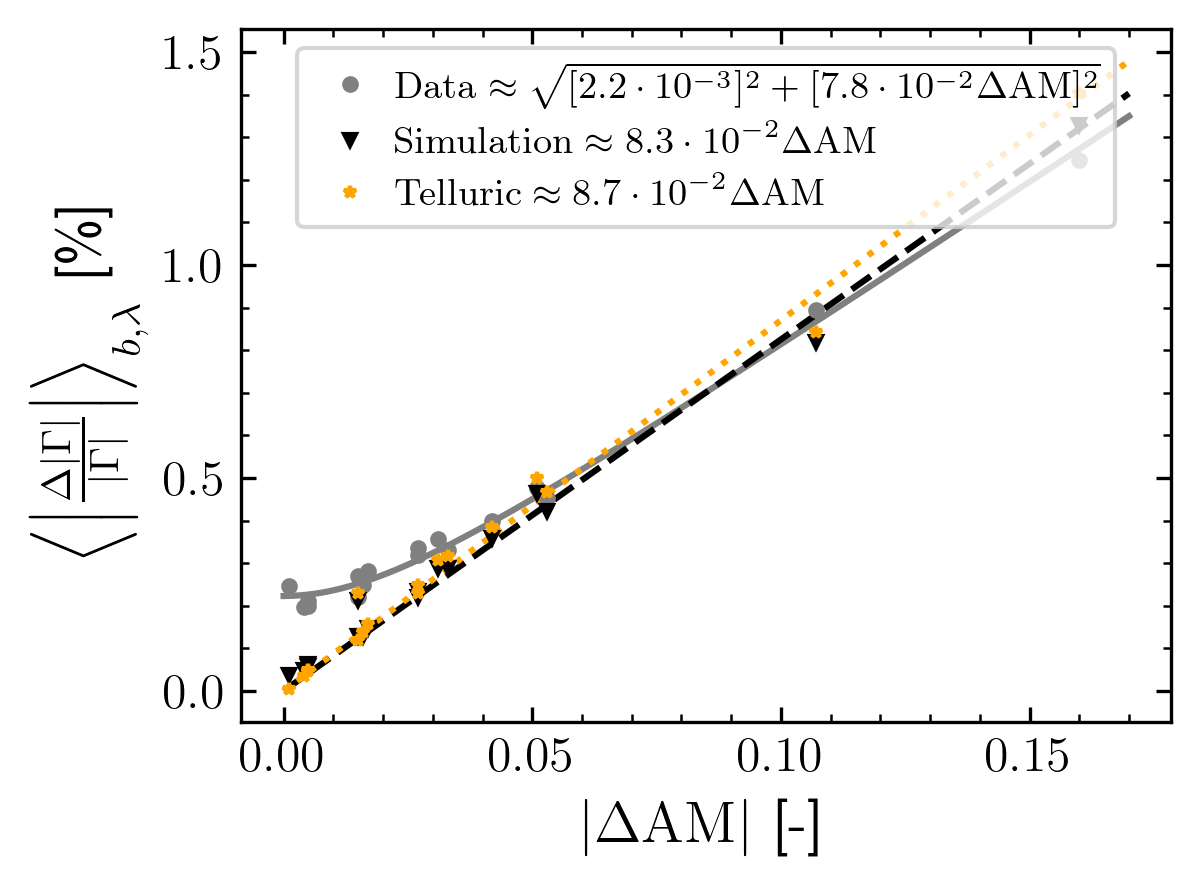

In [22]:
def expo(t,a,b):
    return a*np.exp(b*t)-a

def pol(t,a,b,c):
    return a*t**2+b*t+c

def sqr(t,a,b):
    return np.sqrt(a**2+(b*t)**2)

def lin(t,a):
    return a*t

#AM = []
#WS = []
#Temp = []
#PWV = []
#Theta0 = []
#Seeing = []
#Tau0 = []
#Pressure = []
#Time = []

cmap = plt.cm.coolwarm
param = np.copy(np.abs(np.array(Temp)[1:]-np.array(Temp)[:-1]))
norm = plt.Normalize(vmin=np.min(param), vmax=np.max(param))

dam = np.array([])
dv = np.array([])
dv135 = np.array([])

base = 'gray'
light = adjust_color(base, 1.4)
dark  = adjust_color(base, 0.6)

fig,ax = plt.subplots(1,figsize=(4,3),sharex=True,sharey=True,dpi=300)
for i in range(N2-1):
    dam = np.append(dam,np.abs(AM[i+1]-AM[i]))
    dv = np.append(dv,100*np.mean(np.abs(dvis_poly[i,:])))
    dv135 = np.append(dv135,100*np.mean(np.abs(dvis_poly[i,:,135])))
    if i == 0:
        ax.plot(np.abs(AM[i+1]-AM[i]),100*np.mean(np.abs(dvis_poly[i,:])),'o',color=base,ms=3,
                label=r'$\mathrm{Data} \approx \sqrt{[2.2 \cdot 10^{-3}]^{2} + [7.8 \cdot 10^{-2}\Delta\mathrm{AM}]^{2}}$')
        #ax.plot(np.abs(AM[i+1]-AM[i]),100*np.mean(np.abs(dvis_poly[i,:,135])),'o',color=col[0],ms=3)
    else:
        ax.plot(np.abs(AM[i+1]-AM[i]),100*np.mean(np.abs(dvis_poly[i,:])),'o',color=base,ms=3)
        #ax.plot(np.abs(AM[i+1]-AM[i]),100*np.mean(np.abs(dvis_poly[i,:,135])),'o',color=col[0],ms=3)

popt,_ = curve_fit(sqr,dam,dv,[0.15,1],maxfev=10000)
print(popt)
fv = sqr(np.linspace(0,0.17,100),popt[0],popt[1])
ax.plot(np.linspace(0,0.17,100),fv,color=base,zorder=1)

popt,_ = curve_fit(sqr,dam,dv135,[0.15,1],maxfev=10000)
fv = sqr(np.linspace(0,0.17,100),popt[0],popt[1])
#ax.plot(np.linspace(0,0.17,100),fv,color=col[0],zorder=1)

dam_sim = np.array([])
dv_sim = np.array([])
dv135_sim = np.array([])

for i in range(N2-1):
    dam_sim = np.append(dam_sim,np.abs(AM[i+1]-AM[i]))
    dv_sim = np.append(dv_sim,100*np.mean(np.abs(dvis_poly_sim[i,:])))
    dv135_sim = np.append(dv135_sim,100*np.mean(np.abs(dvis_poly_sim[i,:,135])))
    if i == 0:
        ax.plot(np.abs(AM[i+1]-AM[i]),100*np.mean(np.abs(dvis_poly_sim[i,:])),'v',color='black',ms=3,
                label=r'$\mathrm{Simulation} \approx 8.3 \cdot 10^{-2}\Delta\mathrm{AM}$')
        #ax.plot(np.abs(AM[i+1]-AM[i]),100*np.mean(np.abs(dvis_poly_sim[i,:,135])),'v',color=col[1],ms=3)
    else:
        ax.plot(np.abs(AM[i+1]-AM[i]),100*np.mean(np.abs(dvis_poly_sim[i,:])),'v',color='black',ms=3)
        #ax.plot(np.abs(AM[i+1]-AM[i]),100*np.mean(np.abs(dvis_poly_sim[i,:,135])),'v',color=col[1],ms=3)

popt,_ = curve_fit(lin,dam_sim,dv_sim,[1],maxfev=10000)
print(popt)
fv = lin(np.linspace(0,0.17,100),popt[0])
ax.plot(np.linspace(0,0.17,100),fv,'--',color='black',zorder=1)

popt,_ = curve_fit(lin,dam_sim,dv135_sim,[1],maxfev=10000)
fv = lin(np.linspace(0,0.17,100),popt[0])
#ax.plot(np.linspace(0,0.17,100),fv,color=col[1],zorder=1)

dam_mol = np.array([])
dv_mol = np.array([])
dv135_mol = np.array([])

for i in range(N2-1):
    dam_mol = np.append(dam_mol,np.abs(AM[i+1]-AM[i]))
    dv_mol = np.append(dv_mol,100*np.mean(np.abs(np.log(tm_full[i+1])-np.log(tm_full[i]))))
    dv135_mol = np.append(dv135_mol,100*np.mean(np.abs(np.log(tm_full[i+1,135])-np.log(tm_full[i,135]))))
    if i == 0:
        ax.plot(np.abs(AM[i+1]-AM[i]),100*np.mean(np.abs(np.log(tm_full[i+1])-np.log(tm_full[i]))),'*',color='orange',ms=3,
                label=r'$\mathrm{Telluric} \approx 8.7 \cdot 10^{-2}\Delta\mathrm{AM}$')
        #ax.plot(np.abs(AM[i+1]-AM[i]),100*np.mean(np.abs(tm_full[i+1,135]-tm_full[i,135])),'*',color=col[2],ms=3)
    else:
        ax.plot(np.abs(AM[i+1]-AM[i]),100*np.mean(np.abs(np.log(tm_full[i+1])-np.log(tm_full[i]))),'*',color='orange',ms=3)
        #ax.plot(np.abs(AM[i+1]-AM[i]),100*np.mean(np.abs(tm_full[i+1,135]-tm_full[i,135])),'*',color=col[2],ms=3)

popt,_ = curve_fit(lin,dam_mol,dv_mol,[1],maxfev=10000)
print(popt)
fv = lin(np.linspace(0,0.17,100),popt[0])
ax.plot(np.linspace(0,0.17,100),fv,':',color='orange',zorder=1)

popt,_ = curve_fit(lin,dam_mol,dv135_mol,[1],maxfev=10000)
fv = lin(np.linspace(0,0.17,100),popt[0])
#ax.plot(np.linspace(0,0.17,100),fv,color=col[2],zorder=1)

#ax.legend(loc='upper left',ncols=2,fontsize=12,handletextpad=0.2,columnspacing=0.2)
ax.legend(loc='upper center',fontsize=9,handletextpad=0.2)
ax.set_xlabel(r'$|\Delta\mathrm{AM}|$ [-]',fontsize=14)
ax.set_ylabel(r'$\left\langle\left|\frac{\Delta|\Gamma|}{|\Gamma|}\right |\right\rangle_{b,\lambda}$ [\%]',fontsize=14)
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in',labelsize=12)
ax.minorticks_on()
#ax.set_ylim([-0.1,1.8])
#ax[0].set_yscale('log')
#ax[1].set_xscale('log')
#plt.tight_layout()
plt.savefig('/home/sauter/PhD/SIMTERFERE/Plots/relative_change_airmass.pdf',bbox_inches='tight')
plt.show()

/home/sauter/PhD/SIMTERFERE/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


175.3944223284958 58.78655749824307 40.43306805169294
0.08252347711876935


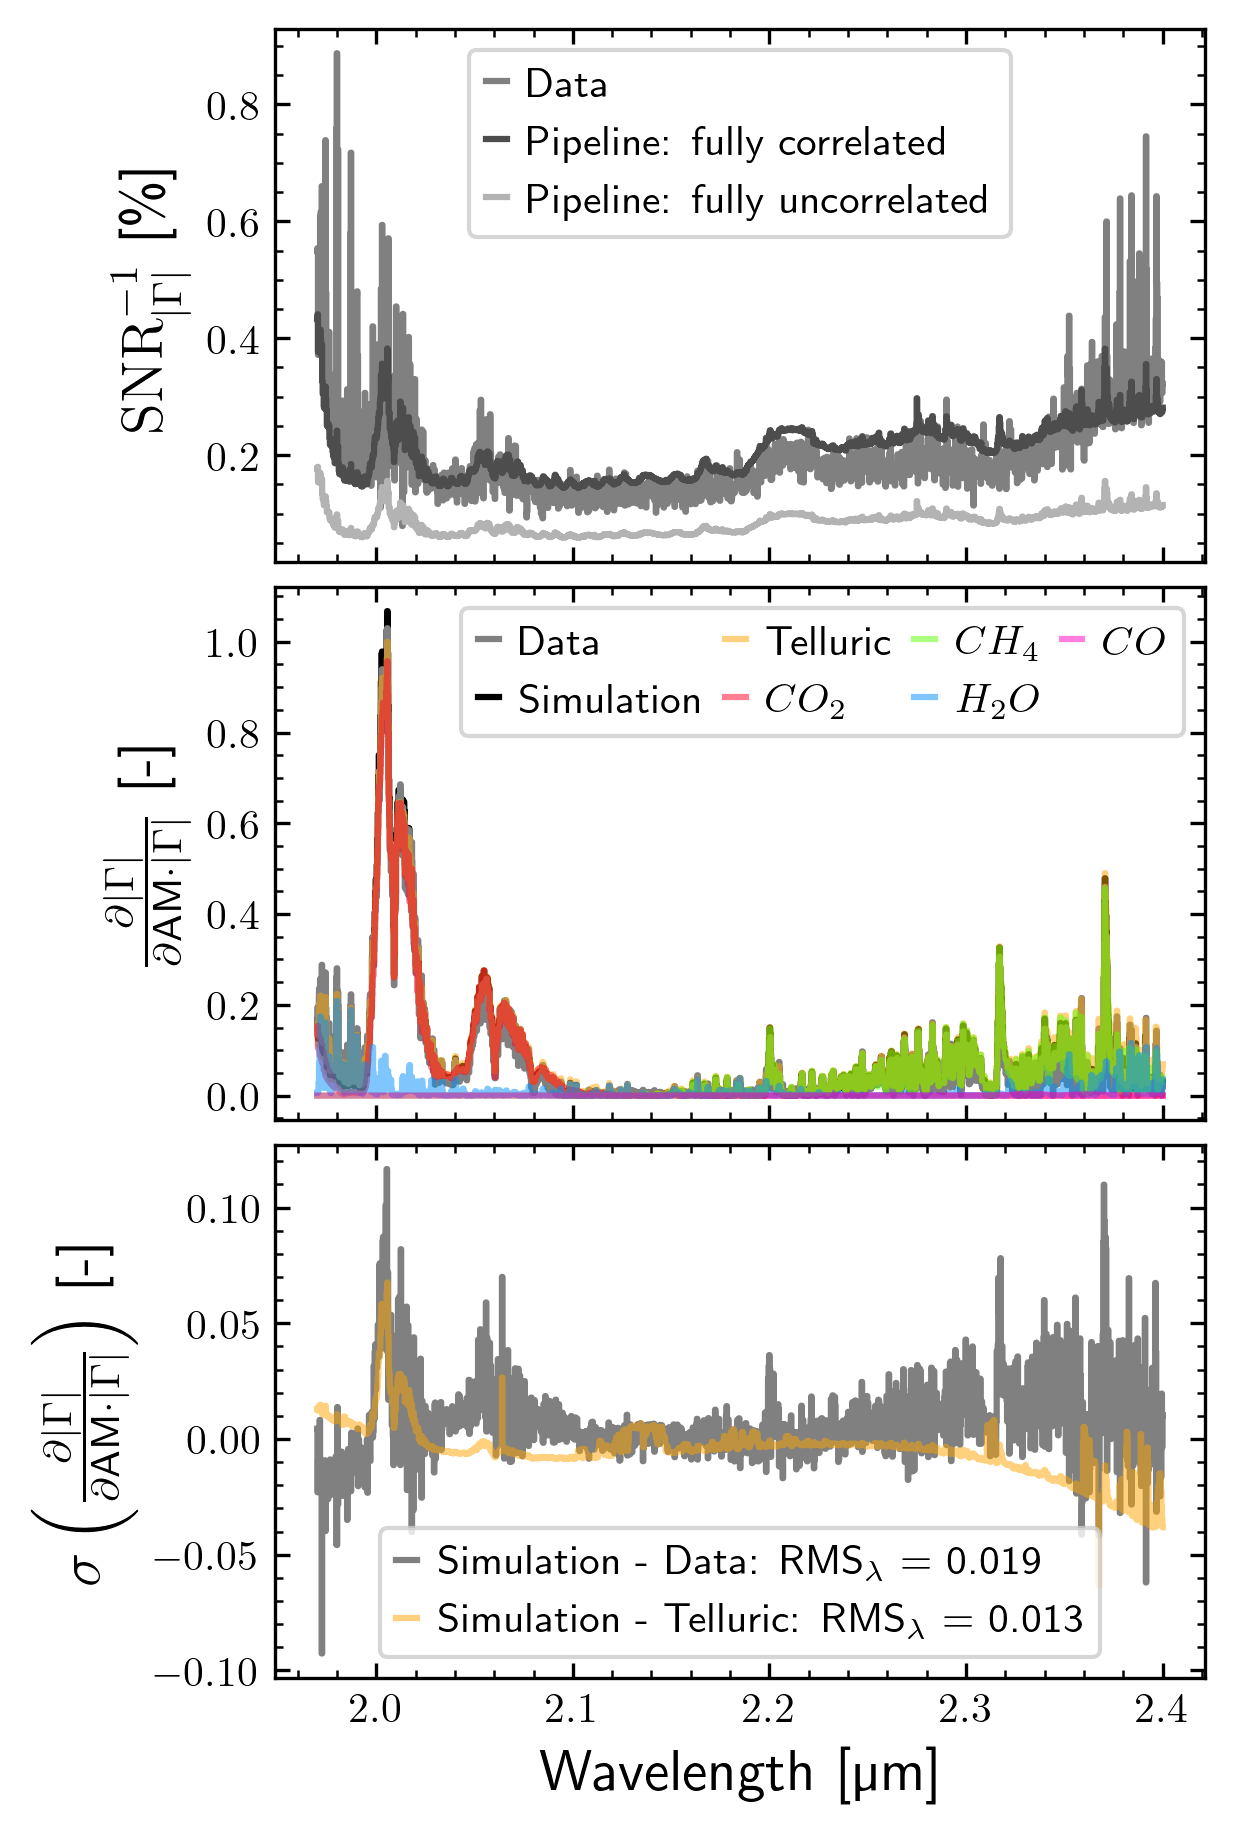

In [23]:
def expo(t,a,b):
    return a*np.exp(b*t)-a

def pol(t,a,b,c):
    return a*t**2+b*t+c

def sqr(t,a,b):
    return np.sqrt(a**2+(b*t)**2)

def lin(t,a):
    return a*t

cm = plt.get_cmap('gist_rainbow')

A = np.empty(1628)
B = np.empty(1628)
B_sim = np.empty(1628)
B_full = np.empty(1628)
B_co2 = np.empty(1628)
B_h2o = np.empty(1628)
B_ch4 = np.empty(1628)
B_co = np.empty(1628)
for j in range(1628):
    dam = np.array([])
    dv = np.array([])
    dv_sim = np.array([])
    dv_full = np.array([])
    dv_co2 = np.array([])
    dv_h2o = np.array([])
    dv_ch4 = np.array([])
    dv_co = np.array([])
    for i in range(N2-1):
        dam = np.append(dam,np.abs(AM[i+1]-AM[i]))
        dv = np.append(dv,100*np.mean(np.abs(dvis_poly[i,:,j])))

        dv_sim = np.append(dv_sim,100*np.mean(np.abs(dvis_poly_sim[i,:,j])))

        dv_full = np.append(dv_full,100*np.mean(np.abs(np.log(tm_full[i+1,j])-np.log(tm_full[i,j]))))
        dv_co2 = np.append(dv_co2,100*np.mean(np.abs(np.log(tm_co2[i+1,j])-np.log(tm_co2[i,j]))))
        dv_h2o = np.append(dv_h2o,100*np.mean(np.abs(np.log(tm_h2o[i+1,j])-np.log(tm_h2o[i,j]))))
        dv_ch4 = np.append(dv_ch4,100*np.mean(np.abs(np.log(tm_ch4[i+1,j])-np.log(tm_ch4[i,j]))))
        dv_co = np.append(dv_co,100*np.mean(np.abs(np.log(tm_co[i+1,j])-np.log(tm_co[i,j]))))

    popt,_ = curve_fit(sqr,dam,dv,[0.15,1],maxfev=10000)
    A[j] = popt[0]/100
    B[j] = popt[1]/100

    popt,_ = curve_fit(lin,dam,dv_sim,[1],maxfev=10000)
    B_sim[j] = popt[0]/100

    popt,_ = curve_fit(lin,dam,dv_full,[1],maxfev=10000)
    B_full[j] = popt[0]/100
    popt,_ = curve_fit(lin,dam,dv_co2,[1],maxfev=10000)
    B_co2[j] = popt[0]/100
    popt,_ = curve_fit(lin,dam,dv_h2o,[1],maxfev=10000)
    B_h2o[j] = popt[0]/100
    popt,_ = curve_fit(lin,dam,dv_ch4,[1],maxfev=10000)
    B_ch4[j] = popt[0]/100
    popt,_ = curve_fit(lin,dam,dv_co,[1],maxfev=10000)
    B_co[j] = popt[0]/100

abs_vis = np.abs(vis)
abs_vis_err = np.sqrt((np.real(vis)*np.real(vis_err))**2+(np.imag(vis)*np.imag(vis_err))**2)/abs_vis

print(np.percentile(abs_vis/abs_vis_err,50),np.percentile(abs_vis/abs_vis_err,84)-np.percentile(abs_vis/abs_vis_err,50),np.percentile(abs_vis/abs_vis_err,50)-np.percentile(abs_vis/abs_vis_err,16))

base = 'gray'
light = adjust_color(base, 1.4)
dark  = adjust_color(base, 0.6)

fig,ax = plt.subplots(3,1,sharex=True,dpi=300,figsize=(4,6),constrained_layout=True)
ax[0].plot(1e6*wave,100*A,ds='steps-mid',color=base,label='Data')
ax[0].plot(1e6*wave,100*np.mean(abs_vis_err/abs_vis,axis=(0,1,2))/np.sqrt(16)*np.sqrt(2),ds='steps-mid',color=dark,label='Pipeline: fully correlated')
ax[0].plot(1e6*wave,100*np.mean(abs_vis_err/abs_vis,axis=(0,1,2))/np.sqrt(16*6)*np.sqrt(2),ds='steps-mid',color=light,label='Pipeline: fully uncorrelated')

ax[1].plot(1e6*wave,B,ds='steps-mid',color=base,label='Data',zorder=1)
ax[1].plot(1e6*wave,B_sim,ds='steps-mid',color='black',label='Simulation',zorder=0)

alpha = 0.5
ax[1].plot(1e6*wave,B_full,ds='steps-mid',color='orange',alpha=alpha,label=r'Telluric',zorder=2)
ax[1].plot(1e6*wave,B_co2,ds='steps-mid',color=cm(0/3),alpha=alpha,label=r'$CO_2$',zorder=3)
ax[1].plot(1e6*wave,B_ch4,ds='steps-mid',color=cm(1/3),alpha=alpha,label=r'$CH_4$',zorder=4)
ax[1].plot(1e6*wave,B_h2o,ds='steps-mid',color=cm(2/3),alpha=alpha,label=r'$H_2O$',zorder=5)
ax[1].plot(1e6*wave,B_co,ds='steps-mid',color=cm(3/3),alpha=alpha,label=r'$CO$',zorder=6)

ax[2].plot(1e6*wave,B_sim-B,ds='steps-mid',color=base,label=r'Simulation - Data: RMS$_{\lambda}$'+f' = {np.sqrt(np.mean((B_sim-B)**2)):.3f}',zorder=0)
ax[2].plot(1e6*wave,B_sim-B_full,ds='steps-mid',color='orange',label=r'Simulation - Telluric: RMS$_{\lambda}$'+f' = {np.sqrt(np.mean((B_sim-B_full)**2)):.3f}',alpha=alpha,zorder=1)
print(np.mean(B_sim))

for i in range(ax.shape[0]):
    ax[i].minorticks_on()
    ax[i].tick_params(axis='both', which='both', top=True, right=True, direction='in',labelsize=10)

ax[0].legend(loc='upper center',fontsize=10,handlelength=0.5,handletextpad=0.5,columnspacing=0.5)
ax[1].legend(loc='upper right',fontsize=10,ncols=4,handlelength=0.5,handletextpad=0.5,columnspacing=0.5)
ax[2].legend(loc='lower center',fontsize=10,handlelength=0.5,handletextpad=0.5,columnspacing=0.5)
ax[0].set_ylabel(r'$\mathrm{SNR}^{-1}_{|\Gamma|}$ [\%]',fontsize=14)
ax[1].set_ylabel(r'$\frac{\partial|\Gamma|}{\partial\text{AM}\cdot|\Gamma|}$ [-]',fontsize=14)
ax[2].set_ylabel(r'$\sigma\left(\frac{\partial|\Gamma|}{\partial\text{AM}\cdot|\Gamma|}\right)$ [-]',fontsize=14)
ax[2].set_xlabel('Wavelength [µm]',fontsize=14)
#ax[1].set_yscale('log')
#ax[1].set_ylim([1e-4,1e0])
plt.savefig('/home/sauter/PhD/SIMTERFERE/Plots/noise_wavelength.pdf',bbox_inches='tight')
plt.show()